# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


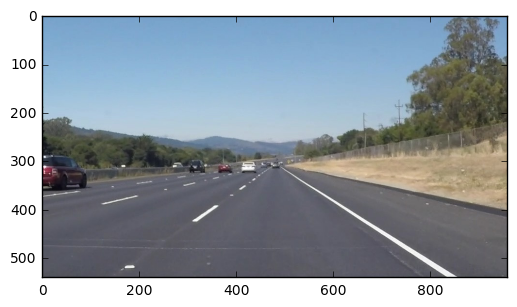

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [107]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """     
    #Regular videos
    grouped_lines = group_lines(lines, 540, 320)
    
    #Challenge video   
    #grouped_lines = group_lines(lines, 720, 440)
    
    for line in grouped_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def group_lines(lines, top_y, bottom_y):
    
    #Group lines by their slope: positive or negative
    lines1 = []
    lines2 = []
    m_pos = []
    m_neg = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x2==x1):
                continue             
            m=((y2-y1)/(x2-x1)) 
            if (m>0): 
                m_pos.append(m)
                if(m>0.45 and m<0.8):
                    lines1.append(line)
            elif (m<0):
                m_neg.append(m)
                if(m>-0.85 and m<-0.6):
                    lines2.append(line)
            
    #Filter out values within 1 std from the mean in case lines are empty (all lines were filtered out)
    if not lines1:
        avg_pos_m = np.mean(m_pos) 
        std_pos_m = np.std(m_pos)
        for line in lines:
            for x1,y1,x2,y2 in line:
                if(x2==x1):
                    continue
                    
                m=((y2-y1)/(x2-x1)) 
                if(m>avg_pos_m-std_pos_m and m<avg_pos_m+std_pos_m):
                    lines1.append(line)  
                    
    if not lines2:
        avg_neg_m = np.mean(m_neg) 
        std_neg_m = np.std(m_neg)
        for line in lines:
            for x1,y1,x2,y2 in line:
                if(x2==x1):
                    continue
                    
                m=((y2-y1)/(x2-x1)) 
                if(m>avg_neg_m-std_neg_m and m<avg_neg_m+std_neg_m):
                    lines2.append(line)  
    
    #Get average position of both positive and negative slope line    
    #Extrapolate to the top and bottom of the left and right lane
    #Left lane
    new_lines = []
    if lines1:
        averageLine1 = np.mean(lines1, axis=0)
        lc = 0
        lm = 0
        for x1,y1,x2,y2 in averageLine1:
            lm = ((y2-y1)/(x2-x1))
            lc= y2-lm*x2
        lx2 = int((top_y-lc)/lm)
        lx1 = int((bottom_y-lc)/lm)
        leftLine = np.array([[lx1],[bottom_y],[lx2],[top_y]])
        new_lines.append([leftLine])
    
    #Right lane
    if lines2:
        averageLine2 = np.mean(lines2, axis=0)
        rc = 0
        rm = 0
        for x1,y1,x2,y2 in averageLine2:
            rm = ((y2-y1)/(x2-x1))
            rc= y2-rm*x2
        rx2 = int((top_y-rc)/rm)
        rx1 = int((bottom_y-rc)/rm)
        rightLine = np.array([[rx1],[bottom_y],[rx2],[top_y]])
        new_lines.append([rightLine])
        
    return new_lines
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    #Draw lines for 
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

True

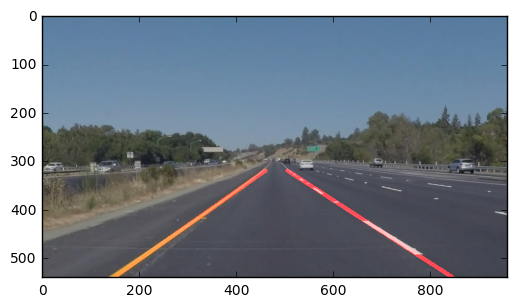

In [87]:
import os
os.listdir("test_images/")
image = mpimg.imread('test_images/solidYellowLeft.jpg')
result = process_image(image)
plt.imshow(result)
cv2.imwrite('test_images/solidYellowLeft.jpg',result)
    

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [108]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    """
    `img` is the input image to process
    
    returns an image with road lines drawn on it
    """
    #Transform to gray scale
    gray_img = grayscale(image)
    
    #Apply gaussian smoothing to gray scale image
    kernel_size = 5
    blur_gray_img = gaussian_blur(gray_img, kernel_size)
    
    #Apply canny edge detector
    low_threshold = 50
    high_threshold = 150
    edges_img = cv2.Canny(blur_gray_img, low_threshold, high_threshold)
    
    #Define mask region
    imshape = image.shape
    #Vertices for regular images
    vertices = np.array([[(0,imshape[0]),(420, 320), (530, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    #Vertices for challenge
    #vertices = np.array([[(200,imshape[0]),(530, 440), (700, 440), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges_img = region_of_interest(edges_img, vertices)
    
    #Get hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 35 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges_img, rho, theta, threshold, min_line_length, max_line_gap)
    
    #Combine image with lines with initial image
    result = weighted_img(line_img, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [109]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4










  0%|          | 0/222 [00:00<?, ?it/s]







  2%|▏         | 4/222 [00:00<00:05, 37.33it/s]







  5%|▍         | 10/222 [00:00<00:05, 41.47it/s]







  7%|▋         | 16/222 [00:00<00:04, 44.36it/s]







  9%|▉         | 21/222 [00:00<00:04, 44.88it/s]







 12%|█▏        | 26/222 [00:00<00:04, 46.12it/s]







 14%|█▍        | 32/222 [00:00<00:03, 48.36it/s]







 17%|█▋        | 38/222 [00:00<00:03, 51.00it/s]







 20%|█▉        | 44/222 [00:00<00:03, 53.01it/s]







 23%|██▎       | 50/222 [00:01<00:04, 38.87it/s]







 25%|██▍       | 55/222 [00:01<00:04, 36.39it/s]







 27%|██▋       | 59/222 [00:01<00:05, 32.22it/s]







 28%|██▊       | 63/222 [00:01<00:06, 23.46it/s]







 30%|██▉       | 66/222 [00:01<00:06, 23.05it/s]







 31%|███       | 69/222 [00:01<00:06, 22.72it/s]







 33%|███▎      | 73/222 [00:02<00:06, 23.89it/s]







 34%|███▍      | 76/222 [00:02<00:06, 22.66it/s]







 36%|███▌      | 80/222 [00:02<00:05, 24.18it/s]



[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.22 s, sys: 924 ms, total: 4.14 s
Wall time: 8.08 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [110]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [111]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4










  0%|          | 0/682 [00:00<?, ?it/s]







  1%|          | 5/682 [00:00<00:14, 46.26it/s]







  1%|▏         | 10/682 [00:00<00:14, 45.37it/s]







  2%|▏         | 14/682 [00:00<00:15, 42.03it/s]







  3%|▎         | 19/682 [00:00<00:15, 42.80it/s]







  4%|▎         | 24/682 [00:00<00:14, 44.05it/s]







  4%|▍         | 28/682 [00:00<00:16, 40.53it/s]







  5%|▍         | 32/682 [00:00<00:17, 36.52it/s]







  5%|▌         | 37/682 [00:00<00:16, 38.30it/s]







  6%|▌         | 42/682 [00:01<00:15, 41.18it/s]







  7%|▋         | 47/682 [00:01<00:17, 36.14it/s]







  7%|▋         | 51/682 [00:01<00:19, 33.01it/s]







  8%|▊         | 55/682 [00:01<00:20, 30.18it/s]







  9%|▊         | 59/682 [00:01<00:23, 26.65it/s]







  9%|▉         | 62/682 [00:01<00:24, 25.22it/s]







 10%|▉         | 65/682 [00:01<00:26, 23.70it/s]







 10%|▉         | 68/682 [00:02<00:26, 23.59it/s]







 10%|█         | 71/682 [00:02<00:27, 22.59it/s]



[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.5 s, sys: 3.3 s, total: 13.8 s
Wall time: 26.8 s


In [112]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

I think this was a very interesting project to start the ND. The current algorithm will fail if the image resolution changes (is manually set up to use either 540x960 or 720x1280), that could be solved by correcting the mask region for image size. The algorithm also fails to detect the yellow line on the bright concrete pavement and the white line when transitioning from concrete pavement to asphalt. A way to correct that would be to change the parameters of the canny edge and hough lines detectors in runtime whenever a line is not found. Another solution would be to smooth the current frame line with previous image lines, however, this might not prove to be enough in the case of a yellow line in a bright concrete road.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [101]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

  self.nchannels))



-0.671755725191
-0.721518987342
0.573964497041
0.616666666667
-0.666666666667
0.0
-0.0178571428571
0.636363636364
-0.66
0.636363636364
-0.243902439024
-0.08
0.0
-0.025974025974
-0.131868131868
0.0923076923077
-0.742857142857
-0.538461538462
-0.436363636364
0.619047619048
-0.047619047619
0.8
0.657142857143
-0.0833333333333
0.571428571429
0.0833333333333
0.571428571429
0.0
-0.621621621622
-0.666666666667
-0.55
-0.242424242424
-0.688888888889
-0.741379310345
[[ 897.625  565.75   963.625  605.5  ]]
[[array([[ 688],
       [ 440],
       [1153],
       [ 720]])], [array([[622],
       [440],
       [215],
       [720]])]]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4










  0%|          | 0/251 [00:00<?, ?it/s]







  1%|          | 3/251 [00:00<00:09, 25.77it/s]

-0.671755725191
-0.721518987342
0.573964497041
0.616666666667
-0.666666666667
0.0
-0.0178571428571
0.636363636364
-0.66
0.636363636364
-0.243902439024
-0.08
0.0
-0.025974025974
-0.131868131868
0.0923076923077
-0.742857142857
-0.538461538462
-0.436363636364
0.619047619048
-0.047619047619
0.8
0.657142857143
-0.0833333333333
0.571428571429
0.0833333333333
0.571428571429
0.0
-0.621621621622
-0.666666666667
-0.55
-0.242424242424
-0.688888888889
-0.741379310345
[[ 897.625  565.75   963.625  605.5  ]]
[[array([[ 688],
       [ 440],
       [1153],
       [ 720]])], [array([[622],
       [440],
       [215],
       [720]])]]
-0.723004694836
-0.670682730924
0.0291262135922
0.0
0.591549295775
0.620689655172
-0.722222222222
-0.0357142857143
-0.246753246753
-0.0714285714286
-0.720930232558
-0.611111111111
-0.0535714285714
0.607843137255
-0.105263157895
-0.714285714286
0.0178571428571
-0.487804878049
0.0
-0.551724137931
0.632653061224
0.829787234043
-0.189189189189
0.576576576577
0.0
0.619047619048









  2%|▏         | 6/251 [00:00<00:10, 24.02it/s]







  3%|▎         | 8/251 [00:00<00:11, 21.47it/s]

-0.670658682635
-0.0515463917526
-0.700440528634
-0.697674418605
0.0133333333333
0.625
0.0113636363636
-0.027027027027
0.666666666667
0.586956521739
-0.691358024691
-0.666666666667
-0.69014084507
-0.700729927007
-0.668711656442
-0.261904761905
0.0285714285714
-0.0125
-0.369565217391
-0.047619047619
-0.22
0.0
-0.707317073171
0.675675675676
0.625
0.628571428571
-0.695652173913
[[ 768.16666667  485.66666667  807.66666667  510.66666667]]
[[array([[ 696],
       [ 440],
       [1138],
       [ 720]])], [array([[626],
       [440],
       [220],
       [720]])]]
0.0
-0.0361445783133
-0.672839506173
-0.722222222222
0.0
-0.661764705882
0.0
-0.268656716418
0.673913043478
0.612244897959
-0.702702702703
-0.144927536232
-0.72972972973
0.0
-0.685185185185
0.592592592593
0.0769230769231
0.0
-0.297297297297
-0.701086956522
-0.685714285714
0.666666666667
-0.269230769231
0.636363636364
-0.666666666667
[[ 803.6  506.8  850.   536.2]]
[[array([[ 698],
       [ 440],
       [1140],
       [ 720]])], [arra









  4%|▍         | 11/251 [00:00<00:11, 21.77it/s]







  6%|▌         | 14/251 [00:00<00:10, 23.67it/s]

-0.72850678733
-0.692307692308
0.0
-0.721518987342
0.626016260163
0.0
0.0
0.578947368421
0.0614035087719
-0.0655737704918
0.0
-0.738461538462
-0.234375
-0.513513513514
-0.445945945946
0.0
0.577777777778
-0.717948717949
0.578125
-0.171428571429
0.611111111111
-0.694444444444
-0.0487804878049
-0.0555555555556
-0.740740740741
0.622641509434
0.0
-0.7
-0.166666666667
-0.621212121212
[[ 890.5         561.83333333  966.16666667  607.16666667]]
[[array([[ 687],
       [ 440],
       [1154],
       [ 720]])], [array([[627],
       [440],
       [233],
       [720]])]]
0.0
0.614285714286
-0.711538461538
-0.751633986928
-0.697278911565
0.577586206897
-0.744680851064
0.64406779661
-0.699507389163
0.0
-0.0673076923077
-0.764705882353
0.555555555556
-0.777777777778
0.651162790698
-0.0681818181818
-0.265625
-0.512195121951
-0.0151515151515
-0.142857142857
0.659090909091
-0.159090909091
-0.513513513514
0.530612244898
0.666666666667
-0.461538461538
0.767441860465
-0.36
-0.782608695652
0.64
0.6363636363









  7%|▋         | 18/251 [00:00<00:09, 25.87it/s]







  8%|▊         | 21/251 [00:00<00:08, 25.99it/s]

-0.754310344828
-0.701421800948
0.0
-0.0307692307692
0.0
-0.702127659574
0.0315789473684
-0.04
-0.758333333333
-0.133333333333
0.642857142857
-0.227848101266
0.627906976744
-0.420289855072
-0.0342857142857
-0.690909090909
-0.119047619048
-0.756756756757
-0.45
-0.65671641791
-0.753246753247
-0.670731707317
-0.690476190476
-0.740740740741
[[ 791.   500.5  833.5  527.5]]
[[array([[ 695],
       [ 440],
       [1136],
       [ 720]])], [array([[622],
       [440],
       [233],
       [720]])]]
-0.722772277228
-0.75
0.0
-0.777108433735
0.0178571428571
-0.0357142857143
-0.137931034483
0.561403508772
-0.0721649484536
0.615384615385
-0.0285714285714
-0.777027027027
-0.65
-0.642857142857
0.027027027027
-0.222222222222
-0.0833333333333
0.0
0.837209302326
0.0810810810811
-0.6
-0.317073170732
0.574074074074
-0.72
-0.257142857143
0.609756097561
[[ 802.5   508.75  853.5   538.75]]
[[array([[ 685],
       [ 440],
       [1161],
       [ 720]])], [array([[620],
       [440],
       [241],
       [720









 10%|▉         | 24/251 [00:00<00:08, 25.58it/s]







 11%|█         | 27/251 [00:01<00:08, 26.53it/s]

-0.701834862385
-0.752808988764
0.614457831325
0.0
0.0
-0.753968253968
0.572916666667
0.617021276596
0.0
-0.507936507937
-0.741379310345
-0.0869565217391
-0.209302325581
0.569230769231
0.65306122449
0.18
-0.047619047619
0.0444444444444
-0.142857142857
-0.492063492063
0.65306122449
0.657894736842
0.579710144928
0.0
0.9
-0.8
0.894736842105
-0.166666666667
0.651162790698
-0.701754385965
-0.711538461538
0.619047619048
[[ 900.8  568.7  973.2  612.6]]
[[array([[ 688],
       [ 440],
       [1150],
       [ 720]])], [array([[616],
       [440],
       [236],
       [720]])]]
-0.70303030303
0.616666666667
0.0336134453782
-0.734513274336
0.00925925925926
0.574193548387
-0.686567164179
-0.625
-0.727272727273
-0.0277777777778
-0.0535714285714
-0.0217391304348
-0.209302325581
-0.0843373493976
0.719298245614
-0.65
0.0350877192982
-0.0232558139535
0.571428571429
-0.734375
0.9
0.628571428571
0.851063829787
0.179487179487
-0.594594594595
0.610169491525
-0.727272727273
-0.716981132075
0.641509433962
[[









 12%|█▏        | 30/251 [00:01<00:08, 27.17it/s]







 13%|█▎        | 33/251 [00:01<00:08, 27.01it/s]

0.0
-0.701298701299
0.0
-0.753246753247
-0.746835443038
-0.04
-0.0434782608696
-0.699346405229
0.608695652174
0.0
0.0
-0.516129032258
-0.482142857143
-0.227272727273
-0.145833333333
0.0
0.0892857142857
-0.047619047619
0.0
-0.0689655172414
0.037037037037
0.763157894737
-0.169811320755
-0.760869565217
-0.692307692308
-0.243243243243
-0.755555555556
[[ 761.5  478.   803.5  506.5]]
[[array([[ 705],
       [ 440],
       [1118],
       [ 720]])], [array([[617],
       [440],
       [233],
       [720]])]]
-0.699619771863
-0.0526315789474
0.0
-0.726618705036
0.0
-0.738095238095
-0.701492537313
-0.046511627907
-0.0265486725664
-0.533333333333
-0.509090909091
0.6
-0.027027027027
-0.162790697674
-0.227272727273
0.744680851064
-0.0381679389313
0.1
0.66
0.0
-0.775
-0.522727272727
0.66
-0.794871794872
-0.783783783784
-0.742857142857
[[ 783.5  495.   834.   528.5]]
[[array([[ 700],
       [ 440],
       [1122],
       [ 720]])], [array([[620],
       [440],
       [233],
       [720]])]]
-0.75
-0.6









 14%|█▍        | 36/251 [00:01<00:08, 26.57it/s]







 16%|█▌        | 40/251 [00:01<00:07, 28.47it/s]

-0.724279835391
-0.0263157894737
0.619402985075
-0.682242990654
-0.604651162791
0.595588235294
-0.628571428571
-0.551282051282
0.0
-0.0308641975309
0.0
-0.694915254237
0.604166666667
0.0
-0.149425287356
-0.229166666667
-0.625
0.628571428571
0.675
-0.702702702703
-0.291666666667
-0.634146341463
0.630434782609
0.611111111111
-0.46511627907
-0.688888888889
-0.726114649682
0.628571428571
[[ 911.5    576.375  975.25   615.75 ]]
[[array([[ 690],
       [ 440],
       [1144],
       [ 720]])], [array([[623],
       [440],
       [219],
       [720]])]]
-0.728813559322
0.0
-0.688888888889
0.0
-0.661764705882
0.59375
-0.634146341463
0.598540145985
-0.704761904762
-0.648936170213
0.0125
-0.693333333333
-0.0188679245283
0.0
0.0
-0.683333333333
-0.131868131868
-0.241758241758
0.813559322034
0.0
-0.540983606557
0.585714285714
-0.0277777777778
0.15
-0.707317073171
-0.707317073171
-0.685714285714
0.025641025641
-0.869565217391
0.782608695652
0.604651162791
-0.65306122449
-0.575
0.6
-0.235294117647
-0









 17%|█▋        | 43/251 [00:01<00:07, 26.83it/s]







 18%|█▊        | 46/251 [00:01<00:07, 27.46it/s]

-0.653846153846
-0.701149425287
0.0
0.0
-0.0232558139535
-0.627450980392
-0.65306122449
0.205128205128
-0.6
0.583333333333
0.0
0.607142857143
-0.6875
-0.231578947368
-0.139534883721
0.0526315789474
-0.102040816327
-0.701149425287
0.0
-0.384615384615
-0.585365853659
0.808510638298
0.625
-0.232558139535
-0.472222222222
0.571428571429
-0.63829787234
[[ 808.5   513.5   861.75  545.25]]
[[array([[ 685],
       [ 440],
       [1154],
       [ 720]])], [array([[627],
       [440],
       [212],
       [720]])]]
-0.7
0.0
-0.649402390438
0.0
-0.0277777777778
0.619047619048
0.0178571428571
-0.0675675675676
-0.658536585366
-0.139534883721
-0.714285714286
0.646153846154
-0.261904761905
-0.688888888889
-0.0454545454545
-0.649484536082
0.0
-0.4
0.0232558139535
-0.047619047619
-0.716417910448
-0.439024390244
0.578947368421
-0.688524590164
-0.675
[[ 836.          527.66666667  891.33333333  562.        ]]
[[array([[ 694],
       [ 440],
       [1145],
       [ 720]])], [array([[633],
       [440],
   









 20%|█▉        | 49/251 [00:01<00:09, 20.33it/s]

-0.672025723473
-0.725738396624
-0.7265917603
-0.0681818181818
0.6
0.0
-0.04
0.573099415205
0.0
-0.26582278481
0.740740740741
-0.444444444444
-0.755102040816
0.0
0.0487804878049
-0.142857142857
-0.509090909091
0.162162162162
-0.0277777777778
0.837837837838
0.860465116279
-0.720930232558
-0.513513513514
-0.0338983050847
0.572580645161
0.860465116279
0.227272727273
0.6
-0.644444444444
0.613636363636
-0.695652173913
[[ 861.          542.          960.66666667  601.83333333]]
[[array([[ 691],
       [ 440],
       [1157],
       [ 720]])], [array([[628],
       [440],
       [231],
       [720]])]]
0.0
-0.674157303371
-0.0833333333333
-0.0535714285714
-0.724279835391
0.623655913978
-0.623376623377
0.573643410853
-0.650406504065
-0.655172413793
-0.0144927536232
-0.106382978723
-0.0140845070423
0.0606060606061
-0.269230769231
0.709677419355
-0.716049382716
-0.347826086957
0.0178571428571
0.76
-0.717391304348
0.610169491525
-0.08
-0.72695035461
0.578947368421
0.568181818182
0.785714285714
0.1









 21%|██        | 52/251 [00:02<00:11, 17.29it/s]

-0.725806451613
-0.69587628866
-0.700636942675
-0.690476190476
-0.0535714285714
-0.662162162162
-0.0694444444444
-0.0149253731343
0.0178571428571
0.0
-0.6
-0.117647058824
0.6
-0.425
0.0
-0.239436619718
0.222222222222
-0.0487804878049
-0.531914893617
0.0
-0.712328767123
-0.0612244897959
0.0
-0.619047619048
0.205128205128
-0.634146341463
-0.116279069767
-0.690476190476
-0.714285714286
[[ 783.  494.  818.  515.]]
[[array([[ 693],
       [ 440],
       [1159],
       [ 720]])], [array([[631],
       [440],
       [227],
       [720]])]]
-0.726368159204
-0.698412698413
-0.646464646465
-0.0344827586207
0.0
-0.0112359550562
-0.833333333333
0.0
-0.716981132075
0.609756097561
0.0
0.595238095238
-0.521126760563
-0.105882352941
-0.246376811594
0.219512195122
0.583333333333
-0.136363636364
-0.46511627907
-0.71186440678
0.0892857142857
-0.822222222222
-0.410714285714
0.0
-0.153846153846
-0.0307692307692
-0.742424242424
-0.631578947368
[[ 789.          500.66666667  828.66666667  524.33333333]]
[[ar









 22%|██▏       | 55/251 [00:02<00:12, 15.65it/s]







 23%|██▎       | 57/251 [00:02<00:11, 16.19it/s]

-0.714285714286
-0.021978021978
-0.696428571429
0.0
0.0
-0.0326797385621
-0.75
-0.745098039216
0.638888888889
-0.448275862069
-0.714285714286
0.620689655172
-0.0178571428571
-0.159090909091
0.0512820512821
-0.717948717949
-0.222222222222
-0.539473684211
0.0
-0.0555555555556
-0.0204081632653
0.6
0.0
-0.755555555556
-0.695652173913
0.627906976744
-0.71186440678
-0.761904761905
0.0
-0.714285714286
-0.52380952381
-0.767441860465
[[ 818.    519.    867.25  549.5 ]]
[[array([[ 690],
       [ 440],
       [1142],
       [ 720]])], [array([[621],
       [440],
       [236],
       [720]])]]
0.0
-0.75
-0.698181818182
0.613333333333
-0.0425531914894
-0.148148148148
-0.448275862069
-0.75
0.652173913043
-0.488372093023
-0.027027027027
0.0
0.628571428571
0.0
0.0277777777778
-0.0793650793651
0.0
0.0285714285714
-0.10101010101
-0.609195402299
-0.0470588235294
0.0
0.714285714286
-0.170731707317
-0.027027027027
-0.714285714286
-0.685714285714
-0.689655172414
-0.458333333333
0.617021276596
[[ 816.8  514









 24%|██▎       | 59/251 [00:02<00:12, 15.44it/s]







 24%|██▍       | 61/251 [00:02<00:12, 15.38it/s]

0.0
-0.69776119403
-0.752173913043
0.579617834395
0.602409638554
-0.0267857142857
-0.592592592593
-0.6
-0.16
0.63829787234
-0.515625
0.0181818181818
0.585365853659
0.0526315789474
0.56862745098
0.0
-0.047619047619
0.161764705882
-0.0810810810811
0.57225433526
0.0625
-0.102941176471
0.0
-0.700636942675
0.586666666667
-0.027027027027
-0.285714285714
0.0357142857143
0.8
-0.0526315789474
-0.134615384615
0.0526315789474
0.144927536232
-0.690476190476
-0.594594594595
0.674418604651
-0.75
[[ 899.5    569.625  983.25   619.125]]
[[array([[ 680],
       [ 440],
       [1153],
       [ 720]])], [array([[622],
       [440],
       [234],
       [720]])]]
-0.697674418605
0.577181208054
-0.752688172043
0.0178571428571
-0.027027027027
0.640625
-0.700483091787
0.578947368421
0.0
-0.674698795181
0.0117647058824
-0.0645161290323
0.632653061224
-0.591836734694
-0.093023255814
-0.0246913580247
-0.047619047619
-0.533333333333
-0.0535714285714
0.76
-0.0151515151515
0.632653061224
0.755555555556
0.0
-0.0666









 25%|██▌       | 63/251 [00:02<00:12, 15.32it/s]







 26%|██▌       | 65/251 [00:03<00:12, 15.28it/s]

-0.651376146789
-0.748603351955
0.0
-0.674418604651
-0.659574468085
-0.0752688172043
-0.666666666667
-0.8
0.589285714286
0.0
-0.0238095238095
-0.676923076923
0.0
-0.0106382978723
-0.0166666666667
0.636363636364
-0.142857142857
0.0
0.027027027027
0.0892857142857
-0.535211267606
-0.159090909091
-0.532258064516
-0.744186046512
0.596153846154
-0.761904761905
0.0
-0.651515151515
[[ 1028.66666667   641.33333333  1083.           674.33333333]]
[[array([[ 697],
       [ 440],
       [1158],
       [ 720]])], [array([[623],
       [440],
       [223],
       [720]])]]
0.0
-0.75
-0.682692307692
-0.578313253012
-0.6
-0.047619047619
-0.0869565217391
0.0
-0.615384615385
-0.0142857142857
-0.0816326530612
-0.0315789473684
0.0609756097561
0.0
-0.146666666667
-0.659574468085
-0.789473684211
-0.594594594595
0.0
-0.212765957447
-0.699115044248
0.0
-0.783783783784
-0.0285714285714
-0.769230769231
-0.657142857143
-0.609756097561
0.0
[[array([[624],
       [440],
       [228],
       [720]])]]
-0.7015706806









 27%|██▋       | 67/251 [00:03<00:12, 14.72it/s]







 27%|██▋       | 69/251 [00:03<00:11, 15.82it/s]

0.0
-0.671532846715
-0.724719101124
-0.634920634921
-0.674698795181
-0.659090909091
-0.047619047619
0.622641509434
0.673913043478
0.0
0.0
-0.0169491525424
-0.128571428571
-0.0178571428571
0.0576923076923
-0.675675675676
-0.681818181818
-0.0666666666667
-0.147058823529
-0.093023255814
0.62962962963
-0.525
-0.0217391304348
-0.85
-0.755102040816
-0.673913043478
[[ 808.33333333  508.          859.33333333  540.66666667]]
[[array([[ 702],
       [ 440],
       [1139],
       [ 720]])], [array([[630],
       [440],
       [221],
       [720]])]]
-0.621052631579
-0.673333333333
-0.72027972028
-0.0416666666667
0.0135135135135
0.0
0.6
-0.0609756097561
0.65
0.579710144928
-0.0851063829787
-0.0515463917526
-0.672727272727
0.0
-0.690476190476
0.0
0.0
-0.148648648649
-0.555555555556
0.0
-0.688888888889
0.625
-0.222222222222
-0.736842105263
-0.740740740741
0.6
-0.725
-0.666666666667
-0.685714285714
-0.671328671329
-0.690476190476
[[ 803.8  504.6  858.4  538. ]]
[[array([[ 698],
       [ 440],
      









 28%|██▊       | 71/251 [00:03<00:11, 15.28it/s]

-0.723880597015
-0.675159235669
0.575539568345
0.0
0.027027027027
0.621212121212
-0.660714285714
-0.672727272727
-0.0263157894737
0.191489361702
0.0322580645161
-0.557692307692
-0.627272727273
-0.140350877193
-0.0560747663551
-0.130952380952
-0.0178571428571
0.0
0.114285714286
0.666666666667
0.584158415842
0.027027027027
-0.626666666667
0.628571428571
0.666666666667
0.611111111111
-0.243902439024
-0.650793650794
-0.65
0.619047619048
-0.714285714286
0.571428571429
-0.674157303371
[[ 861.77777778  539.44444444  935.22222222  584.        ]]
[[array([[ 697],
       [ 440],
       [1159],
       [ 720]])], [array([[635],
       [440],
       [223],
       [720]])]]
0.0
-0.714285714286
-0.748091603053
0.603260869565
-0.698412698413
0.572972972973
-0.747899159664
-0.037037037037
0.0348837209302
-0.0425531914894
-0.0243902439024
0.0
-0.268292682927
-0.145454545455
0.69387755102
0.217391304348
-0.75
0.0
-0.131868131868
-0.74358974359
-0.5625
-0.763157894737
0.0
0.666666666667
0.6
-0.09574468085









 29%|██▉       | 73/251 [00:03<00:12, 14.78it/s]







 30%|██▉       | 75/251 [00:03<00:11, 14.74it/s]







 31%|███       | 77/251 [00:03<00:11, 15.06it/s]

-0.7
-0.722222222222
-0.751004016064
0.0
-0.0847457627119
0.0
0.0
0.0
-0.036496350365
0.619047619048
-0.0555555555556
0.0
-0.234042553191
0.0
-0.027027027027
-0.234375
0.6
-0.139534883721
-0.489795918367
-0.752577319588
0.547619047619
-0.700787401575
0.0
-0.688888888889
[[ 945.          583.66666667  984.66666667  607.        ]]
[[array([[ 700],
       [ 440],
       [1176],
       [ 720]])], [array([[630],
       [440],
       [244],
       [720]])]]
0.0
-0.751037344398
-0.720588235294
-0.0357142857143
-0.0493827160494
0.0
-0.0341463414634
-0.0510204081633
0.0
-0.625
-0.6
-0.16393442623
-0.236842105263
-0.742857142857
0.542857142857
0.555555555556
-0.746031746032
-0.308823529412
0.0923076923077
0.0
0.0
-0.714285714286
-0.263157894737
-0.754716981132
-0.744680851064
[[ 786.   493.   821.5  512.5]]
[[array([[ 689],
       [ 440],
       [1199],
       [ 720]])], [array([[627],
       [440],
       [242],
       [720]])]]
-0.754901960784
0.0
-0.700854700855
-0.0327868852459
-0.7537688442









 31%|███▏      | 79/251 [00:04<00:12, 14.25it/s]







 32%|███▏      | 81/251 [00:04<00:11, 15.36it/s]

-0.752808988764
-0.701086956522
-0.703125
-0.038961038961
-0.027027027027
-0.0359281437126
0.0266666666667
0.592592592593
0.0178571428571
0.611111111111
0.0
-0.027027027027
-0.268292682927
-0.685185185185
-0.135135135135
-0.207547169811
-0.755102040816
-0.102564102564
-0.285714285714
-0.0277777777778
-0.027027027027
0.594594594595
-0.694444444444
-0.755319148936
-0.701754385965
[[ 755.33333333  473.          797.66666667  498.33333333]]
[[array([[ 700],
       [ 440],
       [1168],
       [ 720]])], [array([[635],
       [440],
       [248],
       [720]])]]
-0.7
-0.758865248227
0.0
-0.047619047619
-0.709090909091
-0.0281690140845
0.0
0.549295774648
-0.72972972973
-0.0495867768595
0.641025641026
-0.0933333333333
0.568181818182
-0.0135135135135
0.0666666666667
-0.268656716418
-0.74
-0.254237288136
0.0
0.0
-0.142857142857
-0.710526315789
-0.246153846154
-0.114285714286
-0.648648648649
0.0
0.608695652174
-0.737704918033
-0.0285714285714
-0.720930232558
-0.754237288136
-0.695652173913
[[ 









 33%|███▎      | 83/251 [00:04<00:11, 14.41it/s]

-0.724907063197
-0.754189944134
0.553398058252
0.0
-0.027027027027
-0.0357142857143
0.051724137931
0.0
0.518518518519
-0.0363636363636
0.0
-0.753246753247
-0.0441176470588
0.545454545455
-0.285714285714
-0.727272727273
-0.25641025641
0.514705882353
-0.25974025974
-0.025
-0.744680851064
-0.142857142857
-0.753623188406
0.388888888889
-0.720930232558
-0.102564102564
0.513513513514
0.525
-0.162790697674
-0.0357142857143
-0.0681818181818
-0.756097560976
0.568181818182
0.527777777778
-0.744186046512
-0.755102040816
0.46511627907
[[ 906.44444444  560.33333333  961.55555556  589.44444444]]
[[array([[ 678],
       [ 440],
       [1208],
       [ 720]])], [array([[636],
       [440],
       [257],
       [720]])]]
0.531914893617
0.0151515151515
-0.726775956284
-0.779166666667
-0.0555555555556
0.571428571429
0.0
-0.0987654320988
-0.0357142857143
0.581395348837
-0.297872340426
0.0
-0.0645161290323
0.725490196078
-0.708333333333
0.031746031746
0.0
-0.77990430622
0.567567567568
-0.285714285714
0.636









 34%|███▍      | 85/251 [00:04<00:11, 14.55it/s]







 35%|███▍      | 87/251 [00:04<00:11, 14.70it/s]

[[array([[ 682],
       [ 440],
       [1189],
       [ 720]])], [array([[627],
       [440],
       [257],
       [720]])]]
-0.781609195402
-0.030534351145
0.0
-0.727626459144
0.0
-0.318181818182
-0.784090909091
-0.727272727273
-0.038961038961
0.0105263157895
-0.0217391304348
-0.0693069306931
0.0
-0.0266666666667
-0.0277777777778
0.6
-0.0684931506849
-0.0222222222222
0.0
0.0888888888889
-0.0714285714286
0.0
-0.728813559322
0.594594594595
-0.80487804878
-0.615384615385
-0.0666666666667
-0.0789473684211
0.0857142857143
-0.767857142857
-0.711538461538
-0.0508474576271
[[ 772.5  486.   811.   509. ]]
[[array([[ 695],
       [ 440],
       [1164],
       [ 720]])], [array([[628],
       [440],
       [251],
       [720]])]]
-0.781990521327
-0.727678571429
0.0
0.0
-0.04
-0.78102189781
-0.019801980198
-0.268292682927
-0.936507936508
-0.0366972477064
0.0175438596491
0.0
-0.0555555555556
-0.865671641791
-0.0227272727273
-0.0530973451327
0.0
-0.342465753425
0.0
0.526315789474
-0.395348837209
-0









 35%|███▌      | 89/251 [00:04<00:10, 14.97it/s]







 36%|███▋      | 91/251 [00:04<00:10, 15.50it/s]

-0.752212389381
0.0
-0.835294117647
-0.0459770114943
-0.78021978022
0.0
-0.0526315789474
-0.781954887218
-0.266666666667
-0.0941176470588
0.0869565217391
-0.114285714286
0.131578947368
-0.0612244897959
0.5625
-0.0666666666667
-0.779661016949
-0.108108108108
0.0285714285714
0.573770491803
-0.025
0.0
0.583333333333
-0.761904761905
-1.0
0.0540540540541
-0.0263157894737
0.0232558139535
-0.0227272727273
-0.277777777778
0.564102564103
-0.0208333333333
[[ 781.    490.75  831.    519.25]]
[[array([[ 691],
       [ 440],
       [1183],
       [ 720]])], [array([[632],
       [440],
       [271],
       [720]])]]
0.0
-0.805970149254
0.0
-0.752212389381
0.0379746835443
-0.0617283950617
0.575
-0.810344827586
-0.0449438202247
0.0
-0.771428571429
-0.163636363636
-0.320512820513
0.509803921569
-0.131868131868
-0.776119402985
0.649122807018
-0.0769230769231
-0.0377358490566
0.121951219512
0.0
-0.380952380952
-0.0384615384615
0.133333333333
0.605263157895
-0.0652173913043
-0.0434782608696
0.0
0.0
-0.4










 37%|███▋      | 93/251 [00:05<00:10, 14.65it/s]







 38%|███▊      | 95/251 [00:05<00:10, 14.87it/s]

-0.832167832168
-0.780373831776
0.575342465753
-0.838235294118
0.0
-0.829787234043
0.555555555556
-0.288
-0.0485436893204
-0.0178571428571
-0.113402061856
0.0
-0.136363636364
-0.0357142857143
-0.0181818181818
0.0
-0.0188679245283
0.0
-0.016393442623
-0.944444444444
-0.102941176471
0.0
0.111111111111
-0.0588235294118
-0.222222222222
-2.05555555556
-0.0816326530612
-0.357142857143
-0.781954887218
-0.871428571429
-0.0344827586207
0.527777777778
0.0285714285714
0.157894736842
-0.0263157894737
-0.0526315789474
-0.739130434783
-0.809523809524
-0.8
-0.723404255319
-0.8
-0.763157894737
0.576923076923
-0.780487804878
1.18918918919
-0.105263157895
0.584905660377
-0.46511627907
[[ 895.   557.   977.6  603.8]]
[[array([[ 688],
       [ 440],
       [1182],
       [ 720]])], [array([[626],
       [440],
       [274],
       [720]])]]
-0.751552795031
0.0
-0.837606837607
0.578313253012
0.552941176471
0.0178571428571
-0.307692307692
-0.829268292683
-0.0166666666667
-0.0336538461538
-0.0204081632653
-0









 39%|███▊      | 97/251 [00:05<00:10, 14.88it/s]







 39%|███▉      | 99/251 [00:05<00:10, 15.01it/s]

-0.80829015544
-0.868020304569
0.0
0.569444444444
-0.0519480519481
0.0105263157895
-0.0701754385965
-0.0689655172414
-0.0350877192982
0.539682539683
-0.0327868852459
-0.0674157303371
-0.830188679245
-0.0227272727273
0.0147058823529
-0.305555555556
-0.105263157895
-0.047619047619
-0.0263157894737
-0.145833333333
-0.0521739130435
-0.109375
-0.866279069767
-0.0666666666667
-0.0196078431373
0.575
-0.112676056338
-0.063829787234
-0.0833333333333
-0.0841121495327
0.0655737704918
-0.0487804878049
-0.351351351351
0.0
-0.0689655172414
-0.347826086957
0.535714285714
0.0243902439024
-0.102564102564
-0.274509803922
-0.0277777777778
0.0204081632653
-0.0540540540541
-0.027027027027
-0.828571428571
-0.361111111111
-0.175
-0.865384615385
-0.0512820512821
[[ 1040.75   634.75  1098.5    666.75]]
[[array([[ 689],
       [ 440],
       [1194],
       [ 720]])], [array([[612],
       [440],
       [268],
       [720]])]]
-0.0326086956522
-0.868852459016
-0.807228915663
-0.036496350365
0.0307692307692
-0.06









 40%|████      | 101/251 [00:05<00:09, 15.18it/s]







 41%|████      | 103/251 [00:05<00:09, 15.33it/s]

-0.781609195402
0.0
-0.736842105263
-0.0735294117647
-0.0720720720721
-0.837988826816
0.0
-0.157894736842
-0.0862068965517
0.0629921259843
-0.10447761194
-0.302521008403
0.0714285714286
0.489361702128
0.047619047619
-0.453125
0.0634920634921
-0.016393442623
-0.0731707317073
0.0238095238095
-0.102040816327
-0.0810810810811
0.0
-0.702702702703
-0.27027027027
-0.303370786517
-0.08
-0.108108108108
-0.836734693878
[[ 786.  501.  833.  524.]]
[[array([[ 661],
       [ 440],
       [1233],
       [ 720]])], [array([[617],
       [440],
       [267],
       [720]])]]
-0.0896226415094
0.0
-0.837662337662
0.0
-0.782608695652
0.0
-0.171428571429
-0.030303030303
-0.305555555556
-0.0243902439024
-0.0923076923077
0.5
0.1
-0.123595505618
0.0
0.482142857143
-0.0833333333333
-0.0555555555556
0.027027027027
0.0
0.108108108108
-0.311688311688
0.0217391304348
0.5
0.127272727273
-0.0943396226415
-0.702702702703
-0.84126984127
0.113636363636
0.114754098361
-0.769230769231
[[ 804.66666667  509.33333333  853.









 42%|████▏     | 105/251 [00:05<00:09, 15.96it/s]







 43%|████▎     | 107/251 [00:05<00:09, 15.58it/s]

-0.125412541254
0.0
0.0
-0.705882352941
-0.627906976744
0.0
-0.109090909091
0.521276595745
-0.0232558139535
-0.0434782608696
-0.304347826087
0.0
-0.142857142857
-0.037037037037
-0.102040816327
-0.833333333333
-0.1
-0.765957446809
0.0
0.545454545455
-0.12213740458
[[ 876.5  548.   945.5  584.5]]
[[array([[ 672],
       [ 440],
       [1201],
       [ 720]])], [array([[633],
       [440],
       [248],
       [720]])]]
-0.164285714286
-0.168674698795
-0.145454545455
-0.0909090909091
-0.0222222222222
-0.305084745763
0.578125
-0.701492537313
-0.74358974359
-0.147727272727
0.527559055118
0.0
-0.0416666666667
0.309523809524
-0.685714285714
0.0
0.0
-0.19512195122
-0.0540540540541
-0.162790697674
-0.0652173913043
-0.18
-0.780487804878
-0.189189189189
-0.279069767442
-0.155555555556
-0.684210526316
0.454545454545
0.553571428571
-0.0512820512821
[[ 900.5   564.5   973.25  603.25]]
[[array([[ 666],
       [ 440],
       [1192],
       [ 720]])], [array([[651],
       [440],
       [262],
       [









 43%|████▎     | 109/251 [00:06<00:10, 14.15it/s]







 44%|████▍     | 111/251 [00:06<00:09, 15.24it/s]

0.512820512821
0.0
-0.248677248677
0.53488372093
0.0133333333333
-0.0892857142857
-0.206666666667
0.0
-0.197368421053
0.355555555556
-0.0810810810811
-0.125
0.0
0.491803278689
-0.285714285714
-0.227272727273
-0.0506329113924
0.535087719298
0.0
0.0
-0.127272727273
-0.243902439024
-0.428571428571
-0.181818181818
-0.212121212121
-0.108108108108
-0.102564102564
-0.175
-0.0232558139535
0.257142857143
-0.0806451612903
-0.21568627451
0.516129032258
0.479166666667
0.5
-0.025
-0.584277663851
[[  997.57142857   622.71428571  1064.71428571   657.        ]]
[[array([[ 639],
       [ 440],
       [1188],
       [ 720]])], [array([[1672],
       [ 440],
       [ 102],
       [ 720]])]]
0.516129032258
0.503759398496
-0.109375
0.0
-0.166666666667
-0.339805825243
-0.304761904762
-0.0952380952381
-0.101449275362
-0.0350877192982
-0.0952380952381
-0.108108108108
0.0
-0.108108108108
-0.0444444444444
-0.171428571429
-0.10447761194
-0.297872340426
0.393442622951
-0.114285714286
0.5
0.139534883721
-0.6199422









 45%|████▌     | 113/251 [00:06<00:09, 14.82it/s]







 46%|████▌     | 115/251 [00:06<00:08, 15.34it/s]

0.038961038961
0.0192307692308
-0.0166666666667
-0.304347826087
0.0
-0.162162162162
5.66666666667
8.2
1.02447748935
-0.729223554231
[[ 632.2  664.8  689.4  675.8]]
[[array([[-536],
       [ 440],
       [ 919],
       [ 720]])], [array([[1879],
       [ 440],
       [ 152],
       [ 720]])]]
0.0
0.0
0.0512820512821
-0.0192307692308
-0.302631578947
0.0
-0.0681818181818
-0.0487804878049
0.0
0.0
-1.02766422511
[[array([[13800],
       [  440],
       [-3092],
       [  720]])]]
-0.0185185185185
-0.0361445783133
0.1
-0.0253164556962
-0.171428571429
0.571428571429
-0.311111111111
-0.0980392156863
-0.0263157894737
-0.0857142857143
-0.324324324324
-0.937950591548
[[ 775.  483.  810.  503.]]
[[array([[ 699],
       [ 440],
       [1189],
       [ 720]])], [array([[4551],
       [ 440],
       [-448],
       [ 720]])]]
-0.0238095238095
-0.025
0.52380952381
0.0535714285714
-0.295774647887
0.0
0.538461538462
0.897435897436
-1.11374164673
[[ 783.   491.   823.5  512.5]]
[[array([[ 686],
       [ 4









 47%|████▋     | 117/251 [00:06<00:09, 13.99it/s]

0.0
-0.0348837209302
0.0277777777778
-0.0212765957447
-0.0263157894737
0.568181818182
0.010752688172
0.025641025641
-0.0126582278481
0.644444444444
-0.0217391304348
-0.210526315789
-0.133333333333
-0.306818181818
0.0
-0.0512820512821
0.56
-0.0408163265306
-1.10128338231
[[ 791.66666667  500.          838.          527.33333333]]
[[array([[ 689],
       [ 440],
       [1164],
       [ 720]])], [array([[ 4712],
       [  440],
       [-3165],
       [  720]])]]
-0.0338983050847
-0.0238095238095
0.0
-0.315789473684
0.578947368421
0.576271186441
-0.114285714286
0.0
-0.0714285714286
-0.0161290322581
0.0
-0.121951219512
-0.333333333333
0.585365853659
-0.922830460684
[[ 807.66666667  508.          860.          538.33333333]]
[[array([[ 690],
       [ 440],
       [1173],
       [ 720]])], [array([[ 3487],
       [  440],
       [-1729],
       [  720]])]]
0.0
0.571428571429
0.569444444444
-0.0864197530864
-0.025
0.0
-0.317647058824
0.0649350649351
0.0
-0.025
0.0
-0.0277777777778
0.5833333333









 47%|████▋     | 119/251 [00:06<00:09, 14.56it/s]







 48%|████▊     | 121/251 [00:06<00:08, 15.04it/s]

0.634146341463
0.55652173913
-0.0520833333333
-0.0392156862745
0.0526315789474
-0.0350877192982
0.0
-0.0428571428571
0.0
0.56
-0.309090909091
0.0
0.108108108108
-0.0540540540541
0.0508474576271
0.553846153846
0.0540540540541
-0.222222222222
-0.0285714285714
0.519230769231
-0.285714285714
-0.93364390099
[[ 883.2  558.8  947.8  595. ]]
[[array([[ 671],
       [ 440],
       [1170],
       [ 720]])], [array([[ 3691],
       [  440],
       [-1452],
       [  720]])]]
0.601307189542
0.0
0.570247933884
-0.0138888888889
-0.0444444444444
-0.0149253731343
-0.0181818181818
-0.309090909091
0.571428571429
0.611940298507
-0.0545454545455
0.0
0.644444444444
0.583333333333
-1.3903135473
[[ 900.33333333  569.33333333  986.66666667  620.5       ]]
[[array([[ 682],
       [ 440],
       [1154],
       [ 720]])], [array([[ 6744],
       [  440],
       [-9180],
       [  720]])]]
0.575418994413
-0.016393442623
0.0
0.0
0.60119047619
0.00884955752212
0.0153846153846
0.590909090909
-0.0217391304348
0.0
-0.









 49%|████▉     | 123/251 [00:07<00:09, 13.85it/s]







 50%|████▉     | 125/251 [00:07<00:09, 13.18it/s]

0.571428571429
0.027027027027
0.604316546763
-0.0151515151515
0.0
-0.144927536232
0.056338028169
0.0
0.0178571428571
-0.30612244898
0.570247933884
0.0
0.0408163265306
0.0681818181818
-0.186046511628
0.0677966101695
0.6
-0.637329294254
[[  947.25   596.75  1066.5    666.5 ]]
[[array([[ 679],
       [ 440],
       [1157],
       [ 720]])], [array([[1824],
       [ 440],
       [  81],
       [ 720]])]]
-0.134831460674
-0.0350877192982
0.0
0.047619047619
0.0
0.645833333333
0.0161290322581
-0.0178571428571
-0.19512195122
0.56976744186
-0.111111111111
0.0
0.566666666667
-0.304347826087
0.62
0.567567567568
-0.729593088546
[[ 1017.2   636.6  1073.4   669.8]]
[[array([[ 684],
       [ 440],
       [1158],
       [ 720]])], [array([[2376],
       [ 440],
       [ 356],
       [ 720]])]]
0.0
0.0
-0.03125
0.0
0.0514705882353
-0.134831460674
0.0178571428571
0.047619047619
-0.0243902439024
-0.307692307692
0.0
0.0
-0.107692307692
0.385309683162
-0.84655024634
[[ 699.   559.5  788.   564. ]]
[[array(









 51%|█████     | 127/251 [00:07<00:09, 13.61it/s]

-0.0602409638554
-0.0361445783133
0.0
0.0
0.0
0.666666666667
-0.0208333333333
0.0614035087719
-0.145161290323
-0.239130434783
0.0666666666667
-0.314285714286
-0.230769230769
-0.0277777777778
-0.217391304348
0.0
-0.728110299594
[[ 776.  491.  812.  515.]]
[[array([[ 699],
       [ 440],
       [1119],
       [ 720]])], [array([[1845],
       [ 440],
       [  89],
       [ 720]])]]
0.0
0.0
-0.0425531914894
-0.027027027027
-0.0288461538462
0.047619047619
-0.0324324324324
-0.0263157894737
0.0
0.694444444444
-0.222222222222
0.0
0.675
-0.135593220339
0.0
0.0526315789474
0.0869565217391
0.0
-0.25
-0.922371002469
[[ 784.   497.5  822.   523.5]]
[[array([[ 699],
       [ 440],
       [1109],
       [ 720]])], [array([[ 5171],
       [  440],
       [-1303],
       [  720]])]]
-0.0322580645161
-0.0131578947368
0.0
0.0
0.04
0.666666666667
-0.0327868852459
-0.0217391304348
-0.0238095238095
0.425
0.0
-0.0833333333333
0.0178571428571
0.622222222222
-0.0277777777778
-0.633671935854
[[ 797.   507.   









 51%|█████▏    | 129/251 [00:07<00:08, 13.61it/s]







 52%|█████▏    | 131/251 [00:07<00:08, 13.60it/s]

0.0
-0.025
0.625
0.0285714285714
0.0
-0.0357142857143
0.666666666667
0.620689655172
-0.0192307692308
0.0
0.163265306122
-0.013698630137
-0.0789473684211
0.0975609756098
-0.0666666666667
-0.0363636363636
0.0
-0.0185185185185
-0.1
0.673469387755
-0.660917310567
[[ 805.5   512.5   861.75  548.75]]
[[array([[ 693],
       [ 440],
       [1127],
       [ 720]])], [array([[ 6528],
       [  440],
       [-1927],
       [  720]])]]
-0.04
0.0
-0.0359281437126
0.0140845070423
0.0152671755725
0.594594594595
-0.040404040404
0.0588235294118
0.711538461538
0.0263157894737
-0.0140845070423
0.1
0.0232558139535
0.0263157894737
-0.349206349206
0.694444444444
-0.136363636364
0.0
0.622950819672
0.0263157894737
0.0612244897959
-0.0408163265306
0.619047619048
0.583333333333
-1.17649465649
[[ 807.33333333  511.83333333  857.5         543.66666667]]
[[array([[ 694],
       [ 440],
       [1135],
       [ 720]])], [array([[ 5616],
       [  440],
       [-3858],
       [  720]])]]
-0.0227272727273
0.0
-0.0298









 53%|█████▎    | 133/251 [00:07<00:09, 13.05it/s]

0.0263157894737
0.0
0.0
0.591549295775
0.613636363636
-0.0806451612903
0.0
0.651785714286
0.016393442623
-0.116504854369
-0.68
0.0322580645161
0.0
-0.030303030303
0.015873015873
0.136363636364
0.108108108108
-0.0428571428571
0.0975609756098
-0.0810810810811
-0.36170212766
0.647727272727
0.612244897959
[[ 874.2  554.   955.8  605.2]]
[[array([[ 692],
       [ 440],
       [1138],
       [ 720]])], [array([[606],
       [440],
       [195],
       [720]])]]
0.0
0.605263157895
0.644628099174
0.598870056497
-0.0337078651685
0.0
0.0
0.0
-0.027027027027
-0.025
0.0
0.063829787234
-0.0151515151515
0.6
0.0
0.645161290323
0.6
0.0277777777778
-0.466666666667
0.611111111111
-1.55648954132
[[  943.28571429   595.28571429  1039.42857143   654.85714286]]
[[array([[ 692],
       [ 440],
       [1144],
       [ 720]])], [array([[ 20020],
       [   440],
       [-19739],
       [   720]])]]
-0.0138888888889
0.0
0.580152671756
0.642105263158
0.0
-0.0853658536585
0.104166666667
0.578947368421
-0.04444444









 54%|█████▍    | 135/251 [00:07<00:08, 13.15it/s]







 55%|█████▍    | 137/251 [00:08<00:08, 12.96it/s]

0.0
0.0
-0.047619047619
0.0
0.59649122807
-0.0338983050847
0.0
0.621621621622
-0.0172413793103
-0.125
0.0615384615385
-0.2
-0.104166666667
-0.047619047619
0.0
-0.0394736842105
-0.388888888889
-0.0444444444444
-0.0487804878049
-0.0235294117647
0.627906976744
0.621621621622
0.6
-1.09506739172
[[  981.6   620.2  1054.6   664.8]]
[[array([[ 686],
       [ 440],
       [1144],
       [ 720]])], [array([[ 6851],
       [  440],
       [-2916],
       [  720]])]]
-0.03125
0.0
-0.0175438596491
0.0526315789474
0.0
-0.0535714285714
-0.08
0.162162162162
0.644444444444
-0.46835443038
0.604166666667
0.0
-0.266666666667
0.0
-0.0909090909091
-0.0232558139535
-0.216216216216
-0.492537313433
-0.45652173913
-0.0285714285714
-0.979184902926
[[ 1028.    648.5  1074.5   677.5]]
[[array([[ 693],
       [ 440],
       [1142],
       [ 720]])], [array([[ 2086],
       [  440],
       [-1416],
       [  720]])]]
0.0
-0.027027027027
-0.0217391304348
-0.03125
0.0
0.0
0.0131578947368
-0.203703703704
0.05
-0.01449









 55%|█████▌    | 139/251 [00:08<00:08, 12.51it/s]







 56%|█████▌    | 141/251 [00:08<00:08, 13.37it/s]

0.0
0.0
-0.047619047619
-0.466666666667
-0.0192307692308
0.609756097561
-0.0147058823529
-0.04
0.0
-0.0263157894737
0.0576923076923
-0.0348837209302
-0.301886792453
-0.0227272727273
-0.404761904762
0.0625
0.0425531914894
-0.214285714286
-0.0344827586207
0.0192307692308
-0.027027027027
0.121212121212
-0.106382978723
0.047619047619
-1.19682402582
[[ 774.  498.  815.  523.]]
[[array([[ 678],
       [ 440],
       [1138],
       [ 720]])], [array([[ 5202],
       [  440],
       [-2502],
       [  720]])]]
0.0
-0.025641025641
-0.04
-0.0357142857143
-0.448275862069
0.0697674418605
0.0588235294118
-0.0422535211268
-0.043956043956
0.659574468085
0.046511627907
0.0
0.645833333333
-0.2
-0.025
-0.489361702128
-0.2
-0.14
-0.371428571429
-0.0545454545455
-0.999828272574
[[ 787.5  504.   835.   535. ]]
[[array([[ 689],
       [ 440],
       [1118],
       [ 720]])], [array([[ 2560],
       [  440],
       [-1496],
       [  720]])]]
0.0
0.0
0.0350877192982
0.015873015873
0.0
-0.0324324324324
0.0338









 57%|█████▋    | 143/251 [00:08<00:08, 13.13it/s]

0.0
0.0347826086957
-0.553719008264
-0.0392156862745
0.0175438596491
-0.041095890411
0.661538461538
-0.0263157894737
0.0
-0.0444444444444
-0.527559055118
-0.0144927536232
-0.0549450549451
0.594059405941
-0.0555555555556
-0.12962962963
-0.0512820512821
-0.211267605634
0.0238095238095
0.103896103896
-0.025641025641
0.0
-0.0588235294118
0.0
0.695652173913
-0.238095238095
0.666666666667
0.0135135135135
-0.0666666666667
-0.102564102564
0.0666666666667
-0.552631578947
-0.05
0.612903225806
-0.380952380952
-0.344827586207
-1.07565689724
[[ 843.2  539.8  905.2  579.2]]
[[array([[ 686],
       [ 440],
       [1126],
       [ 720]])], [array([[ 2264],
       [  440],
       [-1187],
       [  720]])]]
-0.0357142857143
0.645161290323
0.0714285714286
0.0
0.630434782609
-0.030303030303
0.163265306122
-0.480769230769
-0.647058823529
-0.466666666667
-0.0408163265306
-0.0571428571429
-0.0510204081633
0.0178571428571
0.0
-0.025
-0.0508474576271
0.0645161290323
0.101694915254
-0.0731707317073
0.171428571









 58%|█████▊    | 145/251 [00:08<00:08, 12.38it/s]







 59%|█████▊    | 147/251 [00:08<00:07, 13.10it/s]

-0.528846153846
-0.0490196078431
0.596638655462
-0.0825688073394
-0.602272727273
0.624203821656
0.0847457627119
0.0
-0.0434782608696
0.0204081632653
0.0
0.0597014925373
0.0810810810811
-0.0253164556962
0.0151515151515
-0.0512820512821
0.0
0.608695652174
0.0681818181818
-0.128205128205
-0.131868131868
-0.0172413793103
-0.41935483871
0.100840336134
0.0408163265306
0.0454545454545
-0.0126582278481
0.0357142857143
0.641025641026
-0.212765957447
0.121951219512
-0.136363636364
0.872727272727
-0.0487804878049
-0.6
0.0487804878049
0.0983606557377
-0.228571428571
0.0
-0.523364485981
-0.0697674418605
0.0526315789474
0.0952380952381
-0.535211267606
0.6
0.611111111111
[[  945.33333333   601.5         1021.16666667   648.        ]]
[[array([[ 681],
       [ 440],
       [1138],
       [ 720]])], [array([[629],
       [440],
       [164],
       [720]])]]
0.1
-0.0851063829787
-0.101265822785
0.0952380952381
0.152542372881
0.0
-0.0512820512821
0.0714285714286
-0.0151515151515
0.0943396226415
-0.57851









 59%|█████▉    | 149/251 [00:09<00:08, 12.67it/s]

-0.122448979592
-0.115942028986
-0.123287671233
-0.141242937853
-0.630769230769
0.0454545454545
-0.537037037037
-0.6
0.0212765957447
-0.0952380952381
-0.19512195122
-0.121951219512
0.0217391304348
-0.186046511628
0.0217391304348
0.0196078431373
0.0222222222222
-0.0833333333333
-0.139784946237
-0.10447761194
-0.152777777778
0.0645161290323
0.0384615384615
0.0833333333333
-0.0769230769231
-0.0166666666667
0.0652173913043
-0.125
-0.0512820512821
-0.108108108108
-0.115384615385
-0.226666666667
0.189393939394
0.0
0.0975609756098
-0.480769230769
-0.162162162162
-0.130434782609
-0.558823529412
-0.379310344828
-0.222222222222
0.0888888888889
0.117647058824
0.0754716981132
-0.425
-0.0833333333333
-0.0952380952381
0.202702702703
0.0869565217391
0.138888888889
0.0
-0.121951219512
0.0491803278689
0.0571428571429
-0.382978723404
-0.0746268656716
-0.0612244897959
-0.102564102564
-0.148936170213
0.6
-0.116279069767
-0.514285714286
-0.6
0.0487804878049
-0.05
0.0375
-0.05
-0.179487179487
-0.13513513513









 60%|██████    | 151/251 [00:09<00:07, 12.85it/s]







 61%|██████    | 153/251 [00:09<00:07, 12.89it/s]

0.0
-0.645502645503
-0.600961538462
-0.027027027027
0.0
-0.592105263158
-0.0289855072464
0.441176470588
0.0759493670886
-0.368421052632
-0.6
0.0
-0.654761904762
-0.207920792079
-0.0571428571429
0.65
0.285714285714
-0.047619047619
-0.406779661017
-0.093023255814
-0.328358208955
0.162162162162
0.617021276596
-0.06
-0.348837209302
-0.615384615385
0.1
0.648648648649
0.288888888889
-0.324324324324
0.1
-0.405797101449
0.875
-0.611111111111
-0.65
0.0
-0.694444444444
-0.078125
0.0857142857143
-0.702702702703
-0.351351351351
-0.684210526316
-0.649122807018
[[ 802.66666667  517.          850.66666667  547.66666667]]
[[array([[ 682],
       [ 440],
       [1120],
       [ 720]])], [array([[619],
       [440],
       [181],
       [720]])]]
-0.648
-0.615384615385
-0.625
0.0
0.0227272727273
-0.631578947368
0.0217391304348
0.552941176471
-0.421052631579
-0.425
-0.682926829268
-0.462962962963
-0.0327868852459
0.0759493670886
-0.236111111111
0.588235294118
-0.641791044776
-0.526315789474
0.02702702702









 62%|██████▏   | 155/251 [00:09<00:07, 13.60it/s]







 63%|██████▎   | 157/251 [00:09<00:06, 13.96it/s]

-0.603603603604
0.592233009709
-0.646226415094
0.0
0.0
-0.0522875816993
-0.424242424242
-0.0833333333333
0.0
0.62015503876
-0.651851851852
-0.444444444444
-0.214285714286
0.592105263158
-0.027027027027
-0.0238095238095
-0.222222222222
0.0629921259843
-0.573770491803
-0.0291262135922
0.0877192982456
0.837837837838
-0.162162162162
0.0
0.80487804878
-0.445945945946
-0.208955223881
-0.111111111111
0.0983606557377
0.0526315789474
-0.685185185185
0.075
0.564102564103
-0.046511627907
-0.606741573034
0.625
-0.111111111111
0.652173913043
[[ 880.5         566.          959.16666667  614.        ]]
[[array([[ 674],
       [ 440],
       [1132],
       [ 720]])], [array([[620],
       [440],
       [177],
       [720]])]]
-0.644444444444
-0.622489959839
0.6
-0.020202020202
0.027027027027
0.047619047619
0.0
0.5625
0.614035087719
0.0
-0.626168224299
-0.45
0.0196078431373
0.0789473684211
0.0
-0.0243902439024
-0.46835443038
0.0923076923077
-0.0394736842105
0.75
-0.245901639344
0.121951219512
0.54
0.75









 63%|██████▎   | 159/251 [00:09<00:06, 13.70it/s]







 64%|██████▍   | 161/251 [00:09<00:06, 14.55it/s]

-0.651515151515
-0.593220338983
-0.565217391304
0.0625
-0.0666666666667
-0.493975903614
-0.0331125827815
-0.603174603175
-0.487179487179
-0.030303030303
-0.527777777778
-0.595744680851
-0.015625
0.0
-0.0298507462687
-0.51724137931
-0.216216216216
-0.604938271605
0.775862068966
0.0666666666667
-0.6
-0.458333333333
-0.7
-0.621621621622
-0.555555555556
-0.666666666667
-0.585365853659
-0.568181818182
[[ 730.  458.  788.  503.]]
[[array([[ 706],
       [ 440],
       [1067],
       [ 720]])], [array([[616],
       [440],
       [176],
       [720]])]]
-0.625
-0.647727272727
-0.0335195530726
-0.45
-0.02
-0.506024096386
0.0
-0.459459459459
0.0681818181818
-0.551724137931
-0.25
0.171428571429
-0.421052631579
-0.646341463415
-0.62
-0.604166666667
-0.694444444444
-0.648648648649
0.0487804878049
-0.659574468085
0.559967408308
[[ 784.   599.5  826.5  602. ]]
[[array([[-1927],
       [  440],
       [ 2832],
       [  720]])], [array([[608],
       [440],
       [171],
       [720]])]]
-0.648648648









 65%|██████▍   | 163/251 [00:10<00:06, 13.60it/s]

0.0243902439024
-0.635135135135
-0.6
-0.517857142857
-0.574193548387
-0.0357142857143
0.0
-0.0161290322581
0.647058823529
-0.210526315789
0.653846153846
-0.102040816327
-0.588235294118
-0.578947368421
0.0645161290323
0.016
0.685185185185
0.136363636364
-0.490384615385
-0.0263157894737
-0.630434782609
0.714285714286
-0.6
-0.634146341463
[[ 780.25  493.    831.75  527.75]]
[[array([[ 701],
       [ 440],
       [1116],
       [ 720]])], [array([[608],
       [440],
       [166],
       [720]])]]
-0.577639751553
-0.540983606557
-0.6
0.0
0.704918032787
0.0
0.629032258065
-0.466666666667
0.0789473684211
-0.6875
0.641791044776
-0.197183098592
-0.446428571429
-0.52
-0.587301587302
0.609756097561
-0.512195121951
-0.601851851852
[[ 819.5   518.    877.25  555.5 ]]
[[array([[ 699],
       [ 440],
       [1130],
       [ 720]])], [array([[611],
       [440],
       [169],
       [720]])]]
-0.623456790123
-0.576687116564
-0.555555555556
-0.5
0.682926829268
0.619047619048
0.722222222222
-0.44736842









 66%|██████▌   | 165/251 [00:10<00:06, 13.50it/s]







 67%|██████▋   | 167/251 [00:10<00:06, 13.74it/s]

-0.624365482234
0.602150537634
-0.563218390805
-0.543209876543
0.645390070922
-0.51724137931
-0.553846153846
-0.54347826087
-0.224299065421
-0.386363636364
-0.510416666667
0.642857142857
0.63829787234
0.078431372549
0.0681818181818
0.9
-0.553571428571
-0.542857142857
-0.63829787234
0.585714285714
0.648648648649
0.725
0.673469387755
0.538461538462
-0.466666666667
-0.581395348837
0.6
[[ 853.2  542.2  914.9  581. ]]
[[array([[ 690],
       [ 440],
       [1135],
       [ 720]])], [array([[628],
       [440],
       [182],
       [720]])]]
-0.600732600733
0.0
0.615384615385
-0.0357142857143
0.6
0.646153846154
-0.56880733945
0.603174603175
0.0
-0.576923076923
-0.607476635514
0.0
-0.428571428571
-0.027027027027
-0.0140845070423
-0.552631578947
-0.226086956522
0.0666666666667
-0.627906976744
0.661016949153
0.0
0.857142857143
-0.604651162791
-0.568421052632
-0.229508196721
-0.576086956522
0.658536585366
-0.584905660377
[[ 909.5         582.          999.16666667  638.        ]]
[[array([[ 682]









 67%|██████▋   | 169/251 [00:10<00:06, 13.64it/s]







 68%|██████▊   | 171/251 [00:10<00:05, 13.55it/s]

-0.621794871795
-0.577049180328
0.0
-0.6
0.0
-0.0408163265306
0.63768115942
-0.0512820512821
0.657142857143
0.0
-0.228346456693
0.6
0.0169491525424
-0.0655737704918
0.0217391304348
-0.010752688172
-0.333333333333
0.0
-0.0181818181818
-0.56862745098
-0.577981651376
0.0487804878049
-0.625
0.0810810810811
0.588235294118
-0.648648648649
-0.371428571429
-0.571428571429
-0.571428571429
-0.685714285714
-0.602941176471
[[  999.75   638.5   1054.75   672.5 ]]
[[array([[ 678],
       [ 440],
       [1131],
       [ 720]])], [array([[645],
       [440],
       [196],
       [720]])]]
-0.599415204678
-0.0361445783133
-0.625668449198
-0.624365482234
0.0133333333333
0.0
-0.237113402062
0.0
0.0
-0.0335570469799
-0.375
-0.614457831325
0.0
-0.418604651163
-0.245614035088
0.0909090909091
-0.351351351351
-0.0857142857143
-0.216216216216
-0.615384615385
-0.612903225806
0.0
-0.139534883721
-0.6
-0.607142857143
-0.528301886792
-0.5
0.744186046512
[[array([[645],
       [440],
       [194],
       [720]])]]










 69%|██████▉   | 173/251 [00:10<00:05, 13.67it/s]

-0.672619047619
-0.623145400593
0.0
-0.016393442623
-0.633802816901
0.0
-0.276595744681
-0.0373134328358
-0.247933884298
0.0
-0.535714285714
0.666666666667
0.619047619048
-0.157894736842
-0.6
0.931818181818
0.0
0.0
-0.457142857143
0.595238095238
0.702702702703
-0.405063291139
-0.714285714286
-0.245901639344
-0.666666666667
-0.623931623932
[[ 789.25  508.    828.5   533.25]]
[[array([[ 683],
       [ 440],
       [1118],
       [ 720]])], [array([[648],
       [440],
       [212],
       [720]])]]
-0.6463878327
-0.672185430464
-0.0441176470588
0.0
0.0
0.0142857142857
-0.666666666667
0.0185185185185
-0.05
-0.421052631579
0.666666666667
-0.259259259259
0.0
-0.65
-0.674033149171
-0.648648648649
0.63829787234
0.0
-0.650602409639
-0.516129032258
-0.263157894737
0.777777777778
-0.659090909091
[[ 776.66666667  494.66666667  820.33333333  524.66666667]]
[[array([[ 697],
       [ 440],
       [1104],
       [ 720]])], [array([[637],
       [440],
       [212],
       [720]])]]
-0.681034482759
-0









 70%|██████▉   | 175/251 [00:10<00:05, 12.87it/s]







 71%|███████   | 177/251 [00:11<00:05, 12.70it/s]

-0.698884758364
-0.652406417112
0.0
-0.623931623932
0.0
-0.0117647058824
0.0
0.597402597403
0.0157480314961
-0.606060606061
-0.246575342466
-0.0877192982456
0.685714285714
0.642857142857
0.0
-0.604838709677
0.0
0.0
-0.611111111111
-0.510638297872
0.603448275862
-0.488888888889
-0.25
-0.636363636364
-0.698979591837
-0.6
-0.638888888889
-0.642857142857
[[ 804.   507.5  864.   545. ]]
[[array([[ 696],
       [ 440],
       [1144],
       [ 720]])], [array([[632],
       [440],
       [206],
       [720]])]]
-0.699248120301
0.0
-0.649606299213
-0.015037593985
0.66
-0.634146341463
-0.0677966101695
-0.0161290322581
0.574257425743
-0.0196078431373
0.0
-0.64
0.657894736842
-0.263157894737
-0.577464788732
-0.693333333333
-0.0212765957447
0.571428571429
-0.638888888889
0.660714285714
-0.684210526316
0.675675675676
-0.649122807018
-0.612903225806
[[ 801.5         505.          857.83333333  540.        ]]
[[array([[ 696],
       [ 440],
       [1147],
       [ 720]])], [array([[629],
       [440]









 71%|███████▏  | 179/251 [00:11<00:06, 10.79it/s]

-0.698305084746
-0.027027027027
0.625
0.578125
-0.66875
-0.0227272727273
0.0
0.0151515151515
-0.0657894736842
-0.700819672131
-0.691358024691
0.5625
-0.691358024691
-0.553191489362
-0.577319587629
0.0
-0.269230769231
0.0
0.559322033898
0.0
0.702127659574
0.525
0.0
-0.714285714286
0.0243902439024
-0.166666666667
0.634615384615
0.615384615385
-0.707317073171
0.682926829268
-0.533333333333
0.630434782609
[[ 892.7  561.6  960.5  603. ]]
[[array([[ 693],
       [ 440],
       [1152],
       [ 720]])], [array([[620],
       [440],
       [216],
       [720]])]]
-0.698630136986
-0.648936170213
-0.655172413793
0.624161073826
0.593220338983
0.0
0.0
-0.027027027027
-0.704225352113
-0.0378787878788
-0.46511627907
0.0535714285714
-0.27027027027
0.613636363636
0.046511627907
0.666666666667
-0.611111111111
-0.413043478261
0.0576923076923
-0.477272727273
-0.305555555556
0.923076923077
-0.648936170213
-0.621621621622
-0.0243902439024
0.833333333333
-0.777777777778
0.0
-0.641025641026
-0.645161290323
0









 72%|███████▏  | 181/251 [00:11<00:06, 11.51it/s]







 73%|███████▎  | 183/251 [00:11<00:05, 11.48it/s]

-0.671875
-0.705202312139
0.0
-0.7
-0.68085106383
0.0171428571429
-0.0454545454545
-0.0666666666667
-0.267605633803
-0.0677966101695
-0.727272727273
0.625
-0.6
0.410256410256
0.0
0.571428571429
-0.485714285714
-0.531914893617
-0.0405405405405
-0.2
-0.675213675214
0.621621621622
-0.621621621622
[[ 1039.           651.33333333  1078.66666667   675.33333333]]
[[array([[ 689],
       [ 440],
       [1152],
       [ 720]])], [array([[628],
       [440],
       [219],
       [720]])]]
-0.7
-0.671480144404
-0.0263157894737
-0.7
-0.0355029585799
0.0330578512397
-0.578947368421
0.0
-0.528301886792
-0.542857142857
-0.025
-0.26582278481
0.0285714285714
-0.0307692307692
-0.771428571429
-0.659574468085
-0.675
-0.686274509804
-0.487804878049
-0.257142857143
-0.681818181818
0.0727969348659
[[ 1150.   673.  1185.   674.]]
[[array([[-7004],
       [  440],
       [ 2795],
       [  720]])], [array([[629],
       [440],
       [222],
       [720]])]]
-0.671875
-0.705426356589
-0.0695652173913
-0.7005076









 74%|███████▎  | 185/251 [00:11<00:05, 12.41it/s]

0.0
-0.672727272727
-0.700854700855
-0.03125
0.627906976744
-0.692307692308
0.6
-0.708333333333
0.0
-0.666666666667
-0.0192307692308
-0.7
-0.26582278481
-0.0285714285714
-0.707070707071
-0.119047619048
0.0857142857143
0.658536585366
0.6
-0.692307692308
-0.693548387097
[[ 795.5   502.75  836.5   528.25]]
[[array([[ 694],
       [ 440],
       [1144],
       [ 720]])], [array([[632],
       [440],
       [227],
       [720]])]]
-0.673469387755
-0.701612903226
0.0
-0.0357142857143
-0.0359281437126
-0.7125
0.647058823529
0.010989010989
0.012987012987
0.615384615385
-0.673267326733
-0.705882352941
-0.277777777778
-0.490196078431
0.621621621622
0.0
-0.681818181818
-0.53125
0.615384615385
-0.708860759494
-0.486486486486
-0.514285714286
0.621621621622
-0.74
[[ 811.4  512.   854.6  539. ]]
[[array([[ 696],
       [ 440],
       [1144],
       [ 720]])], [array([[633],
       [440],
       [229],
       [720]])]]
-0.722846441948
-0.674242424242
0.0
0.0
-0.0655737704918
-0.721649484536
-0.8947368









 75%|███████▍  | 187/251 [00:12<00:05, 11.76it/s]

-0.675675675676
-0.723636363636
-0.0504201680672
0.0
-0.676470588235
0.556818181818
0.666666666667
-0.0149253731343
0.0
0.0
-0.265957446809
0.653846153846
0.0614035087719
-0.662162162162
0.0
-0.471428571429
-0.72380952381
0.545454545455
0.684210526316
-0.0161290322581
-0.473684210526
-0.047619047619
-0.509433962264
-0.669421487603
-0.698630136986
-0.255813953488
0.075
[[ 810.2  511.8  869.2  547.8]]
[[array([[ 692],
       [ 440],
       [1151],
       [ 720]])], [array([[629],
       [440],
       [229],
       [720]])]]
-0.72602739726
-0.695945945946
0.0
-0.650602409639
-0.0310559006211
0.0178571428571
0.590361445783
-0.263157894737
0.0162601626016
0.65
0.682926829268
-0.661016949153
0.6
-0.727272727273
-0.726315789474
-0.0243902439024
0.512820512821
-0.122448979592
-0.714285714286
-0.626666666667
-0.0144927536232
0.0555555555556
0.673913043478
-0.421052631579
0.657142857143
0.0263157894737
0.648648648649
0.58
0.641025641026
-0.688524590164
[[ 852.3  536.7  899.3  565.9]]
[[array([[ 









 75%|███████▌  | 189/251 [00:12<00:05, 11.28it/s]







 76%|███████▌  | 191/251 [00:12<00:05, 11.83it/s]

-0.0357142857143
0.0
-0.751004016064
-0.699669966997
0.56880733945
0.602272727273
-0.750943396226
0.034188034188
-0.70036101083
0.0
-0.14
-0.25
0.615384615385
0.622641509434
-0.510204081633
0.569620253165
-0.559322033898
-0.281690140845
-0.0350877192982
0.0350877192982
0.0
-0.0188679245283
0.615384615385
0.627450980392
[[ 883.42857143  552.28571429  965.14285714  601.14285714]]
[[array([[ 695],
       [ 440],
       [1163],
       [ 720]])], [array([[630],
       [440],
       [243],
       [720]])]]
-0.75092936803
-0.7004048583
0.0
-0.70303030303
0.597122302158
0.577464788732
0.0
-0.0172413793103
-0.0689655172414
-0.0701754385965
-0.244897959184
-0.557692307692
0.0612244897959
0.593220338983
0.0
0.0
0.0
-0.145161290323
-0.296875
-0.6
0.568181818182
-0.0384615384615
-0.74
-0.575757575758
0.590163934426
-0.228571428571
-0.553571428571
0.642857142857
-0.658536585366
[[ 878.          548.33333333  959.16666667  596.33333333]]
[[array([[ 694],
       [ 440],
       [1168],
       [ 720]])]









 77%|███████▋  | 193/251 [00:12<00:04, 11.67it/s]







 78%|███████▊  | 195/251 [00:12<00:04, 11.52it/s]

-0.718446601942
0.0
-0.674698795181
-0.777777777778
-0.047619047619
-0.0434782608696
-0.686274509804
0.0
-0.0816326530612
-0.742857142857
-0.777070063694
-0.25
0.047619047619
-0.0363636363636
-0.246575342466
0.0
-0.6
-0.761904761905
-0.561403508772
-0.0487804878049
0.0
-0.8
-0.741935483871
-0.692307692308
-0.72972972973
0.0
[[array([[624],
       [440],
       [247],
       [720]])]]
-0.777777777778
-0.702702702703
0.0
-0.652173913043
-0.747126436782
-0.047619047619
0.0192307692308
-0.796875
-0.741379310345
0.0
-0.0196078431373
-0.58064516129
-0.761904761905
-0.125
0.0
0.0
-0.268656716418
0.657142857143
0.657142857143
-0.246575342466
-0.54
-0.0487804878049
0.027027027027
-0.795918367347
0.583333333333
-0.738095238095
[[ 785.33333333  490.          820.66666667  512.33333333]]
[[array([[ 706],
       [ 440],
       [1149],
       [ 720]])], [array([[622],
       [440],
       [249],
       [720]])]]
-0.778280542986
-0.0266666666667
-0.677419354839
0.05
-0.647058823529
-0.0322580645161
0









 78%|███████▊  | 197/251 [00:13<00:05,  9.65it/s]

-0.722891566265
-0.777777777778
0.0
-0.0714285714286
-0.0357142857143
0.0
0.6
-0.602739726027
-0.576923076923
0.0178571428571
-0.017094017094
0.585365853659
0.0810810810811
-0.774647887324
-0.127659574468
-0.796875
0.104166666667
-0.25
0.0
-0.241379310345
-0.561403508772
-0.796296296296
-0.676056338028
0.607843137255
0.595744680851
-0.714285714286
[[ 807.75  503.    855.    531.25]]
[[array([[ 702],
       [ 440],
       [1170],
       [ 720]])], [array([[628],
       [440],
       [247],
       [720]])]]
-0.778301886792
-0.725321888412
0.0
0.0
-0.0535714285714
-0.0957446808511
-0.625
0.587301587302
-0.583333333333
0.590163934426
-0.233333333333
0.0294117647059
0.0
-0.8
-0.257575757576
0.0
-0.811320754717
-0.8
-0.705263157895
-0.861111111111
[[ 815.   510.   877.   546.5]]
[[array([[ 696],
       [ 440],
       [1171],
       [ 720]])], [array([[628],
       [440],
       [251],
       [720]])]]
0.0178571428571
0.0
-0.75
-0.778409090909
-0.674418604651
-0.04
0.575
-0.651162790698
-0.03









 79%|███████▉  | 199/251 [00:13<00:04, 10.58it/s]

-0.753246753247
0.0114942528736
-0.719008264463
-0.0337078651685
0.616279069767
-0.747663551402
-0.540540540541
-0.0314465408805
0.0227272727273
0.57
-0.627659574468
-0.245283018868
0.0178571428571
-0.243243243243
-0.0192307692308
0.591836734694
-0.74
0.589743589744
-0.769230769231
-0.804597701149
0.0
-0.166666666667
-0.659090909091
-0.754838709677
0.56862745098
-0.68
[[ 836.4  520.6  901.4  558.8]]
[[array([[ 699],
       [ 440],
       [1175],
       [ 720]])], [array([[627],
       [440],
       [245],
       [720]])]]
-0.724770642202
0.60162601626
-0.753768844221
0.55223880597
0.0
0.0
-0.716666666667
-0.0357142857143
-0.0847457627119
-0.76
-0.025
-0.0175438596491
-0.0238095238095
-0.257575757576
-0.254545454545
0.1
-0.6
-0.0277777777778
-0.558139534884
0.539682539683
0.0
0.617021276596
-0.717391304348
0.610169491525
-0.727272727273
-0.0217391304348
-0.269230769231
-0.745454545455
-0.257142857143
-0.753521126761
0.558139534884
[[ 863.5         539.33333333  941.66666667  584.5      









 80%|████████  | 201/251 [00:13<00:04, 10.26it/s]







 81%|████████  | 203/251 [00:13<00:04, 11.37it/s]







 82%|████████▏ | 205/251 [00:13<00:03, 12.48it/s]

-0.722513089005
0.0
-0.75355450237
0.551136363636
0.59649122807
0.0344827586207
0.0
-0.742857142857
0.0
-0.0957446808511
0.607142857143
-0.762711864407
-0.721518987342
0.603448275862
-0.257142857143
-0.709090909091
0.0
-0.763157894737
0.0
-0.583333333333
0.594594594595
-0.243902439024
0.0
-0.0192307692308
-0.744186046512
0.542372881356
0.654545454545
0.563636363636
[[ 922.375  572.5    998.625  616.875]]
[[array([[ 694],
       [ 440],
       [1175],
       [ 720]])], [array([[628],
       [440],
       [249],
       [720]])]]
-0.724907063197
-0.758928571429
-0.0491803278689
0.0
-0.0434782608696
0.552
0.575
-0.0337078651685
0.0
-0.757142857143
0.639344262295
-0.733333333333
-0.552631578947
-0.6
0.0
0.0
-0.260869565217
-0.735849056604
-0.268292682927
0.551724137931
-0.707317073171
0.587301587302
-0.758064516129
0.56862745098
-0.744186046512
0.555555555556
-0.685185185185
[[  956.85714286   592.57142857  1030.28571429   634.71428571]]
[[array([[ 691],
       [ 440],
       [1178],
      









 82%|████████▏ | 207/251 [00:13<00:03, 12.36it/s]

-0.778225806452
-0.728260869565
-0.051724137931
-0.015503875969
0.0178571428571
-0.72641509434
0.027027027027
-0.25
-0.479166666667
0.047619047619
-0.0487804878049
-0.770833333333
0.714285714286
0.05
-0.146341463415
0.641025641026
-0.764705882353
-0.538461538462
0.621621621622
-0.488372093023
-0.781456953642
-0.0392156862745
-0.0571428571429
0.0819672131148
-0.703703703704
-0.777777777778
-0.790697674419
-0.763636363636
[[ 789.33333333  495.33333333  826.33333333  519.66666667]]
[[array([[ 705],
       [ 440],
       [1130],
       [ 720]])], [array([[627],
       [440],
       [257],
       [720]])]]
-0.781094527363
-0.726368159204
0.0
0.0
0.0
-0.730337078652
-0.781818181818
-0.781456953642
-0.0510204081633
-0.0359281437126
0.666666666667
-0.625
0.615384615385
0.636363636364
0.0
-0.256756756757
-0.727272727273
-0.6
-0.857142857143
0.0892857142857
0.0
-0.636363636364
-0.171428571429
-0.615384615385
[[ 773.66666667  487.33333333  814.33333333  513.33333333]]
[[array([[ 699],
       [ 44









 83%|████████▎ | 209/251 [00:13<00:03, 12.55it/s]







 84%|████████▍ | 211/251 [00:14<00:03, 12.51it/s]

-0.78313253012
0.0
-0.726907630522
-0.0526315789474
0.0
-0.037037037037
-0.0172413793103
0.59375
0.0
0.655737704918
-0.731958762887
-0.692307692308
-0.784810126582
-0.567567567568
-0.257575757576
0.631578947368
-0.790697674419
0.577464788732
-0.51724137931
0.583333333333
0.0
-0.666666666667
-0.314285714286
-0.769230769231
-0.769230769231
0.621621621622
-0.047619047619
[[ 792.16666667  497.33333333  843.33333333  528.5       ]]
[[array([[ 698],
       [ 440],
       [1157],
       [ 720]])], [array([[630],
       [440],
       [256],
       [720]])]]
-0.7265625
0.0
-0.752808988764
-0.0520833333333
0.0106382978723
-0.144927536232
-0.766666666667
-0.726744186047
0.602409638554
0.604651162791
-0.769230769231
-0.253968253968
0.594594594595
0.0
-0.733333333333
-0.754098360656
-0.75
0.602409638554
0.585365853659
-0.447368421053
-0.25
-0.0285714285714
-0.742857142857
0.666666666667
[[ 827.83333333  518.83333333  883.16666667  552.5       ]]
[[array([[ 698],
       [ 440],
       [1158],
      









 85%|████████▍ | 213/251 [00:14<00:03, 11.63it/s]

-0.781115879828
-0.726937269373
0.0322580645161
-0.0357142857143
0.6
0.0
-0.0645161290323
0.55303030303
-0.0196078431373
-0.775510204082
0.622222222222
-0.243243243243
-0.731707317073
0.644444444444
-0.142857142857
-0.755102040816
-0.245283018868
0.613636363636
0.555555555556
0.0
0.142857142857
-0.0181818181818
0.596153846154
-0.552631578947
-0.577777777778
-0.742424242424
-0.771428571429
0.0625
-0.777777777778
-0.681818181818
[[ 851.42857143  530.85714286  932.28571429  578.28571429]]
[[array([[ 696],
       [ 440],
       [1173],
       [ 720]])], [array([[629],
       [440],
       [257],
       [720]])]]
-0.75
-0.781954887218
-0.0357142857143
0.0
0.56862745098
0.625
-0.712328767123
0.00884955752212
0.578378378378
-0.781659388646
-0.0320855614973
-0.16
-0.269841269841
0.571428571429
-0.583333333333
0.581395348837
0.0804597701149
-0.75
0.586206896552
-0.567567567568
-0.755555555556
-0.0963855421687
0.0
0.583333333333
-0.769230769231
0.567164179104
-0.757575757576
0.0394736842105
[[ 8









 86%|████████▌ | 215/251 [00:14<00:02, 12.16it/s]







 86%|████████▋ | 217/251 [00:14<00:02, 12.91it/s]

-0.783625730994
-0.751798561151
-0.0681818181818
-0.791666666667
0.0
-0.0277777777778
0.553571428571
0.00884955752212
-0.75
-0.766666666667
0.0
0.595505617978
-0.025
-0.770833333333
0.586956521739
-0.783783783784
-0.285714285714
-0.0178571428571
0.0
-0.0714285714286
0.6
-0.459459459459
-0.268292682927
0.5625
-0.125
0.54347826087
[[ 1018.16666667   625.          1081.66666667   661.33333333]]
[[array([[ 694],
       [ 440],
       [1184],
       [ 720]])], [array([[632],
       [440],
       [266],
       [720]])]]
-0.80859375
0.0
-0.751724137931
-0.05
0.0
-0.04
0.0
-0.025
0.03
-0.753191489362
-0.811320754717
-0.281690140845
-0.0555555555556
-0.770833333333
0.564102564103
-0.777777777778
-0.763157894737
[[ 1071.   651.  1110.   673.]]
[[array([[ 696],
       [ 440],
       [1193],
       [ 720]])], [array([[630],
       [440],
       [268],
       [720]])]]
-0.754716981132
-0.807560137457
0.0
0.010752688172
-0.753846153846
0.564102564103
0.0
0.0
-0.809160305344
-0.0212765957447
-0.84057









 87%|████████▋ | 219/251 [00:14<00:02, 13.07it/s]

-0.807547169811
-0.755681818182
-0.754716981132
-0.812865497076
-0.0263157894737
-0.047619047619
0.0178571428571
0.521739130435
0.063829787234
0.585365853659
0.0
-0.0833333333333
-0.813333333333
-0.0555555555556
-0.145454545455
-0.295081967213
-0.0222222222222
0.078431372549
-0.604651162791
-0.581395348837
0.547619047619
-0.0416666666667
-0.751243781095
-0.736842105263
[[ 794.33333333  496.33333333  837.33333333  520.        ]]
[[array([[ 691],
       [ 440],
       [1200],
       [ 720]])], [array([[628],
       [440],
       [266],
       [720]])]]
-0.777251184834
-0.835748792271
-0.027027027027
-0.0331491712707
0.0
0.528301886792
0.0
-0.625
0.512195121951
0.0165289256198
-0.0243902439024
-0.0833333333333
-0.28125
-0.189189189189
-0.589743589744
-0.854545454545
-0.8
-0.854545454545
-0.631578947368
-0.815789473684
-0.8
-0.836734693878
-0.291666666667
[[ 809.   505.5  856.   530. ]]
[[array([[ 683],
       [ 440],
       [1220],
       [ 720]])], [array([[626],
       [440],
       [26









 88%|████████▊ | 221/251 [00:14<00:02, 12.29it/s]







 89%|████████▉ | 223/251 [00:15<00:02, 12.96it/s]

-0.836283185841
-0.753521126761
-0.0428571428571
-0.0666666666667
-0.760563380282
-0.0428571428571
0.0138888888889
0.0
0.52380952381
-0.833333333333
-0.027027027027
0.58904109589
-0.294117647059
-0.0526315789474
0.0344827586207
-0.114754098361
-0.0307692307692
-0.744680851064
0.666666666667
-0.838709677419
-0.744186046512
0.0540540540541
-0.809523809524
-0.758064516129
0.540540540541
[[ 814.25  508.25  871.75  541.  ]]
[[array([[ 694],
       [ 440],
       [1186],
       [ 720]])], [array([[623],
       [440],
       [273],
       [720]])]]
-0.779166666667
-0.836283185841
0.0
0.0
0.551020408163
-0.84
0.0
-0.0666666666667
0.0759493670886
0.590163934426
-0.650602409639
-0.276923076923
-0.778350515464
0.631578947368
0.6
0.549019607843
-0.0204081632653
-0.6
0.0
0.576470588235
-0.3
-0.631578947368
[[ 833.83333333  520.66666667  898.5         558.        ]]
[[array([[ 694],
       [ 440],
       [1179],
       [ 720]])], [array([[626],
       [440],
       [269],
       [720]])]]
-0.7727272









 90%|████████▉ | 225/251 [00:15<00:01, 13.13it/s]

0.0
-0.817307692308
0.528735632184
0.0
-0.776315789474
0.58
-0.0487804878049
-0.820512820513
-0.803738317757
-0.76
-0.0864197530864
0.6
-0.268656716418
-0.16
-0.511627906977
0.533333333333
0.1
0.68
-0.0681818181818
-0.805555555556
0.0315789473684
-0.245283018868
0.0
-0.833333333333
0.0555555555556
-0.628571428571
-0.805194805195
-0.790697674419
0.584905660377
-0.0694444444444
-0.758620689655
0.591836734694
[[ 900.42857143  560.42857143  987.71428571  610.        ]]
[[array([[ 688],
       [ 440],
       [1181],
       [ 720]])], [array([[623],
       [440],
       [269],
       [720]])]]
-0.834905660377
-0.777777777778
0.559322033898
-0.0634920634921
0.0135135135135
0.528409090909
0.0777777777778
-0.0357142857143
-0.835897435897
-0.0363636363636
-0.6
0.528409090909
0.514285714286
0.620689655172
-0.266666666667
0.0
-0.647887323944
0.0
-0.258620689655
-0.725490196078
0.565789473684
-0.8
-0.8
0.6
-0.266666666667
[[  923.71428571   573.71428571  1020.71428571   627.        ]]
[[array([[ 68









 90%|█████████ | 227/251 [00:15<00:01, 12.87it/s]







 91%|█████████ | 229/251 [00:15<00:01, 13.05it/s]

-0.777272727273
0.0
-0.047619047619
-0.818181818182
-0.780701754386
0.518518518519
0.0
-0.0864197530864
-0.636363636364
0.047619047619
-0.7
0.596774193548
-0.264705882353
0.0
-0.80487804878
-0.253731343284
-0.809523809524
-0.780821917808
0.0555555555556
-0.805555555556
-0.0625
-0.781818181818
-0.27027027027
-0.778947368421
[[ 1040.    641.5  1098.    674. ]]
[[array([[ 680],
       [ 440],
       [1180],
       [ 720]])], [array([[632],
       [440],
       [268],
       [720]])]]
-0.836842105263
-0.778280542986
-0.04
0.0
0.0
-0.0185185185185
-0.229508196721
-0.835164835165
-0.755319148936
-0.672131147541
-0.0235294117647
-0.266666666667
-0.0192307692308
0.675
-0.776649746193
-0.472727272727
0.571428571429
0.0
0.0285714285714
-0.777777777778
-0.753623188406
-0.139534883721
-0.0192307692308
-0.212765957447
[[ 744.5  471.   782.   494.5]]
[[array([[ 695],
       [ 440],
       [1141],
       [ 720]])], [array([[629],
       [440],
       [271],
       [720]])]]
-0.836842105263
0.0
0.0
-0









 92%|█████████▏| 231/251 [00:15<00:01, 12.78it/s]

-0.783068783069
-0.753768844221
-0.0507246376812
-0.0363636363636
-0.795454545455
0.0222222222222
-0.255319148936
0.0
-0.745762711864
0.0
-0.80487804878
0.0
0.58
0.574468085106
-0.754716981132
-0.279069767442
0.0731707317073
-0.230769230769
-0.0222222222222
-0.523076923077
-0.803921568627
0.590909090909
-0.527777777778
-0.0579710144928
-0.739130434783
[[ 795.          502.33333333  842.          529.66666667]]
[[array([[ 687],
       [ 440],
       [1169],
       [ 720]])], [array([[627],
       [440],
       [262],
       [720]])]]
-0.738461538462
0.0
0.0
-0.834951456311
-0.753246753247
-0.714285714286
-0.645833333333
-0.0666666666667
-0.712328767123
0.566666666667
-0.0727272727273
-0.239130434783
0.0614035087719
-0.725
-0.596153846154
-0.834586466165
0.0
-0.241379310345
0.571428571429
-0.552631578947
0.0
-0.842105263158
-0.763157894737
-0.262295081967
-0.229508196721
[[ 808.5  507.5  866.5  540.5]]
[[array([[ 689],
       [ 440],
       [1181],
       [ 720]])], [array([[626],
      









 93%|█████████▎| 233/251 [00:15<00:01, 13.43it/s]







 94%|█████████▎| 235/251 [00:15<00:01, 13.57it/s]

-0.804733727811
0.0
-0.75
-0.828571428571
-0.748201438849
0.0
0.577777777778
0.027027027027
-0.047619047619
0.573033707865
-0.013698630137
0.0
-0.166666666667
-0.0851063829787
-0.836734693878
-0.238805970149
0.589743589744
-0.212765957447
-0.794871794872
-0.603773584906
0.56862745098
0.558139534884
-0.744186046512
-0.255813953488
0.578947368421
[[ 858.16666667  536.66666667  916.5         570.16666667]]
[[array([[ 689],
       [ 440],
       [1177],
       [ 720]])], [array([[624],
       [440],
       [258],
       [720]])]]
-0.750877192982
-0.808139534884
0.0
-0.027027027027
0.0625
0.589285714286
0.583333333333
-0.0833333333333
-0.809523809524
-0.227272727273
0.586206896552
-0.027027027027
0.56862745098
0.619047619048
0.0
-0.533333333333
0.0
-0.230769230769
-0.146341463415
-0.0571428571429
-0.764705882353
0.568965517241
-0.576923076923
-0.753246753247
-0.794871794872
0.0810810810811
-0.555555555556
[[ 858.          536.5         920.16666667  572.83333333]]
[[array([[ 692],
       [ 









 94%|█████████▍| 237/251 [00:16<00:01, 13.98it/s]







 95%|█████████▌| 239/251 [00:16<00:00, 14.39it/s]

-0.801724137931
-0.750877192982
-0.775510204082
0.576923076923
0.551724137931
-0.809338521401
0.0
0.0
0.561403508772
-0.05
-0.22972972973
-0.047619047619
-0.0957446808511
0.0674157303371
-0.859649122807
-0.230769230769
0.0
-0.0612244897959
0.74358974359
-0.525
0.571428571429
0.692307692308
-0.583333333333
-0.822222222222
-0.857142857143
-0.235294117647
0.552631578947
0.571428571429
-0.752032520325
[[ 913.75   566.375  985.875  608.625]]
[[array([[ 698],
       [ 440],
       [1176],
       [ 720]])], [array([[623],
       [440],
       [263],
       [720]])]]
-0.750889679715
-0.808429118774
0.594827586207
-0.0310559006211
0.0
0.569444444444
0.0629921259843
-0.542857142857
-0.0344827586207
0.586206896552
-0.229166666667
-0.48
0.590909090909
0.0
0.581395348837
0.558139534884
0.6
-0.326086956522
-0.813008130081
-0.027027027027
-0.753086419753
-0.0833333333333
-0.22641509434
0.611111111111
-0.8
[[ 1007.5     624.625  1064.      657.75 ]]
[[array([[ 692],
       [ 440],
       [1170],
     









 96%|█████████▌| 241/251 [00:16<00:00, 14.66it/s]







 97%|█████████▋| 243/251 [00:16<00:00, 14.83it/s]

-0.808764940239
-0.754716981132
0.0
0.0136054421769
-0.0666666666667
-0.758241758242
-0.581818181818
-0.0161290322581
-0.22972972973
-0.513513513514
-0.234375
0.567567567568
0.0909090909091
0.638888888889
0.567567567568
-0.8125
-0.0526315789474
0.0
-0.0571428571429
-0.730158730159
-0.607142857143
-0.0375
-0.722222222222
[[ 764.          480.          800.66666667  501.66666667]]
[[array([[ 696],
       [ 440],
       [1170],
       [ 720]])], [array([[627],
       [440],
       [261],
       [720]])]]
-0.759493670886
0.0
-0.77358490566
-0.808163265306
0.0
0.604651162791
-0.0684931506849
-0.648648648649
-0.228571428571
0.675
-0.0277777777778
-0.0210526315789
0.0612244897959
-0.102564102564
-0.047619047619
0.666666666667
-0.626666666667
-0.625
-0.81
-0.230769230769
-0.1
-0.794871794872
0.6
-0.8
-0.25
-0.728813559322
[[ 775.75  486.25  819.    513.75]]
[[array([[ 703],
       [ 440],
       [1143],
       [ 720]])], [array([[628],
       [440],
       [257],
       [720]])]]
0.0
-0.753906









 98%|█████████▊| 245/251 [00:16<00:00, 15.37it/s]

-0.808035714286
-0.756756756757
-0.0357142857143
-0.0243902439024
-0.701149425287
0.0238095238095
0.0
0.632653061224
0.605263157895
0.0178571428571
0.55421686747
0.0
0.0
-0.649350649351
0.555555555556
-0.119047619048
-0.214285714286
-0.717948717949
0.684210526316
-0.12962962963
-0.245614035088
-0.594594594595
0.638888888889
-0.725
-0.793650793651
-0.826923076923
-0.818181818182
-0.766666666667
-0.780487804878
0.648648648649
0.56
-0.741935483871
[[ 811.     510.125  859.125  539.   ]]
[[array([[ 694],
       [ 440],
       [1160],
       [ 720]])], [array([[622],
       [440],
       [254],
       [720]])]]
0.0
0.0
-0.792207792208
-0.704225352113
-0.751054852321
-0.0747663551402
0.545454545455
-0.0377358490566
0.576923076923
-0.820512820513
-0.754385964912
-0.772727272727
0.0666666666667
-0.623188405797
-0.213333333333
-0.723404255319
0.582278481013
-0.241379310345
-0.047619047619
0.583333333333
-0.754385964912
-0.08
-0.0238095238095
-0.714285714286
0.545454545455
-0.75
-0.814814814815










 98%|█████████▊| 247/251 [00:16<00:00, 13.88it/s]







100%|█████████▉| 250/251 [00:16<00:00, 15.37it/s]

-0.75117370892
-0.782258064516
0.571428571429
0.615384615385
0.027027027027
-0.046511627907
-0.0816326530612
-0.777777777778
0.0
-0.6
0.612903225806
-0.027027027027
-0.623376623377
0.568421052632
0.607142857143
0.0615384615385
0.0
0.030303030303
-0.0606060606061
-0.241935483871
-0.830985915493
0.727272727273
-0.0666666666667
-0.260869565217
0.578947368421
-0.74358974359
0.589743589744
-0.0208333333333
0.677966101695
0.0227272727273
0.723404255319
-0.744186046512
0.568181818182
-0.016393442623
-0.719298245614
[[ 903.81818182  564.27272727  964.18181818  601.54545455]]
[[array([[ 702],
       [ 440],
       [1156],
       [ 720]])], [array([[627],
       [440],
       [253],
       [720]])]]
-0.688888888889
0.0
0.0
-0.808823529412
-0.725663716814
-0.649122807018
0.551948051948
0.58
-0.05
0.0619469026549
-0.791666666667
-0.047619047619
0.552631578947
-0.725
-0.240740740741
0.652173913043
-0.0821917808219
-0.646153846154
-0.829787234043
-0.789473684211
-0.625
0.6
0.816326530612
0.568965517









100%|██████████| 251/251 [00:16<00:00, 14.77it/s]

0.0
-0.778280542986
-0.7
0.0
-0.047619047619
-0.675
-0.710843373494
0.0
-0.047619047619
0.0434782608696
-0.0862068965517
0.75
-0.226666666667
0.0
-0.122448979592
-0.774647887324
0.571428571429
0.583333333333
-0.764705882353
0.710526315789
-0.222222222222
-0.703296703297
-0.738095238095
0.594594594595
[[ 754.2  474.4  791.4  498.4]]
[[array([[ 700],
       [ 440],
       [1134],
       [ 720]])], [array([[627],
       [440],
       [245],
       [720]])]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.3 s, sys: 1.91 s, total: 9.2 s
Wall time: 18.9 s


In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))